#Imports

In [1]:
from __future__ import print_function
from urllib.request import urlretrieve
from torch.utils.data import Dataset
from torch import optim

import os
import pickle as pkl
import numpy as np
import torch

import torch
import torch.utils.data

from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import clear_output

import imageio
from datetime import datetime

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Parameters

In [2]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

batch_size = 64
log_interval = 16
epochs = 20
bottleneck_dim = 32
use_conv = True
plot_images = True
plot_loss = True
save_images = False

root = os.getcwd()
print(f"Current working directory: {root}")

Current working directory: /content


# Load data

## MNIST binary

In [0]:
def load_mnist_binarized(root):
    datapath = os.path.join(root, 'bin-mnist')
    if not os.path.exists(datapath):
        os.makedirs(datapath)
    dataset = os.path.join(datapath, "mnist.pkl.gz")

    if not os.path.isfile(dataset):

        datafiles = {
            "train": "http://www.cs.toronto.edu/~larocheh/public/"
                     "datasets/binarized_mnist/binarized_mnist_train.amat",
            "valid": "http://www.cs.toronto.edu/~larocheh/public/datasets/"
                     "binarized_mnist/binarized_mnist_valid.amat",
            "test": "http://www.cs.toronto.edu/~larocheh/public/datasets/"
                    "binarized_mnist/binarized_mnist_test.amat"
        }
        datasplits = {}
        for split in datafiles.keys():
            print("Downloading %s data..." % (split))
            datasplits[split] = np.loadtxt(urlretrieve(datafiles[split])[0])

        pkl.dump([datasplits['train'], datasplits['valid'], datasplits['test']], open(dataset, "wb"))

    x_train, x_valid, x_test = pkl.load(open(dataset, "rb"))
    return x_train, x_valid, x_test


class BinMNIST(Dataset):
    """Binary MNIST dataset"""

    def __init__(self, data, device='cpu', transform=None):
        h, w, c = 28, 28, 1
        self.device = device
        self.data = torch.tensor(data, dtype=torch.float).view(-1, c, h, w)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample.to(self.device)


def get_binmnist_datasets(root, device='cpu'):
    x_train, x_valid, x_test = load_mnist_binarized(root)
    x_train = np.append(x_train, x_valid, axis=0)  # https://github.com/casperkaae/LVAE/blob/master/run_models.py (line 401)
    return BinMNIST(x_train, device=device), BinMNIST(x_test, device=device), BinMNIST(x_test, device=device)

## Quick, Draw!

In [0]:
class Sketch(Dataset):
    """Sketch dataset"""

    def __init__(self, data, labels, device='cpu', transform=None):
        h, w, c = 28, 28, 1
        self.device = device
        self.data = torch.tensor(data, dtype=torch.float).view(-1, c, h, w)
        print(data.shape)
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            sample = self.transform(sample)
            label = self.transform(label)
        return sample, label


def convert_img2norm(img_list, ypixels, xpixels):
    norm_list = img_list.copy()
    norm_list = norm_list.astype('float32') / 255
    norm_list = np.reshape(norm_list, (len(norm_list), ypixels, xpixels, 1))
    
    return norm_list
    
    
def load_sketches(root):
    data_dir = "gdrive/My Drive/dataset"
    #data_dir = "gdrive/My Drive/DTU/Semester 2"
    categories = ['cat', 'dog', 'pig']
    #categories = ['apple', 'banana']

    xpixels = 28
    ypixels = 28

    category_filenames = []
    for cat_name in categories:
        filename = os.path.join(data_dir, "full_numpy_bitmap_" + cat_name + ".npy")
        category_filenames.append(filename)

    n_take_train = 8000  # number of training images from each category
    n_take_test = 1600   # number of test images from each category
    
    # Load images
    n_categories = len(categories)  # number of classes

    # Training images and labels
    x_train = []
    y_train = []
    
    # Test images and labels
    x_test = []
    y_test = []  

    for i_category, category in enumerate(categories):
        data = np.load(category_filenames[i_category])
        n_data = len(data)
        
        print("[%d/%d] Reading category index %d: '%s' (%d images: take %d training, take %d test)" %
              (i_category+1, n_categories, i_category, category, n_data, n_take_train, n_take_test))

        for j, data_j in enumerate(data):
            img = np.array(data_j).reshape((ypixels, xpixels))
            if j < n_take_train:   # append to training set
                x_train.append(img)
                y_train.append(i_category)  
            elif j - n_take_train < n_take_test: # append to test set
                x_test.append(img)
                y_test.append(i_category) 
            else:
                break

    # Convert to numpy
    x_train = np.array(x_train)
    y_train = np.array(y_train) 
    x_test = np.array(x_test)
    y_test = np.array(y_test)  
    
    # Convert greyscale images to have values [0,1] and reshape to (n, ypixels, xpixels, 1)
    x_train = convert_img2norm(x_train, ypixels, xpixels)
    x_test = convert_img2norm(x_test, ypixels, xpixels)
    
    return Sketch(x_train, y_train, device=device), Sketch(x_test, y_test, device=device)

In [0]:
# LOAD BINARY MNIST
# x_train, x_valid, x_test = get_binmnist_datasets(root)

# train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, shuffle=True, pin_memory=cuda)
# test_loader  = torch.utils.data.DataLoader(x_test, batch_size=batch_size, shuffle=True, pin_memory=cuda)

In [6]:
# LOAD QUICKDRAW (SKETCHES) DATASET
x_train, x_test = load_sketches(root)

train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, shuffle=True, pin_memory=cuda)
test_loader  = torch.utils.data.DataLoader(x_test, batch_size=batch_size, shuffle=True, pin_memory=cuda)

[1/3] Reading category index 0: 'cat' (123202 images: take 8000 training, take 1600 test)
[2/3] Reading category index 1: 'dog' (152159 images: take 8000 training, take 1600 test)
[3/3] Reading category index 2: 'pig' (186770 images: take 8000 training, take 1600 test)
(24000, 28, 28, 1)
(4800, 28, 28, 1)


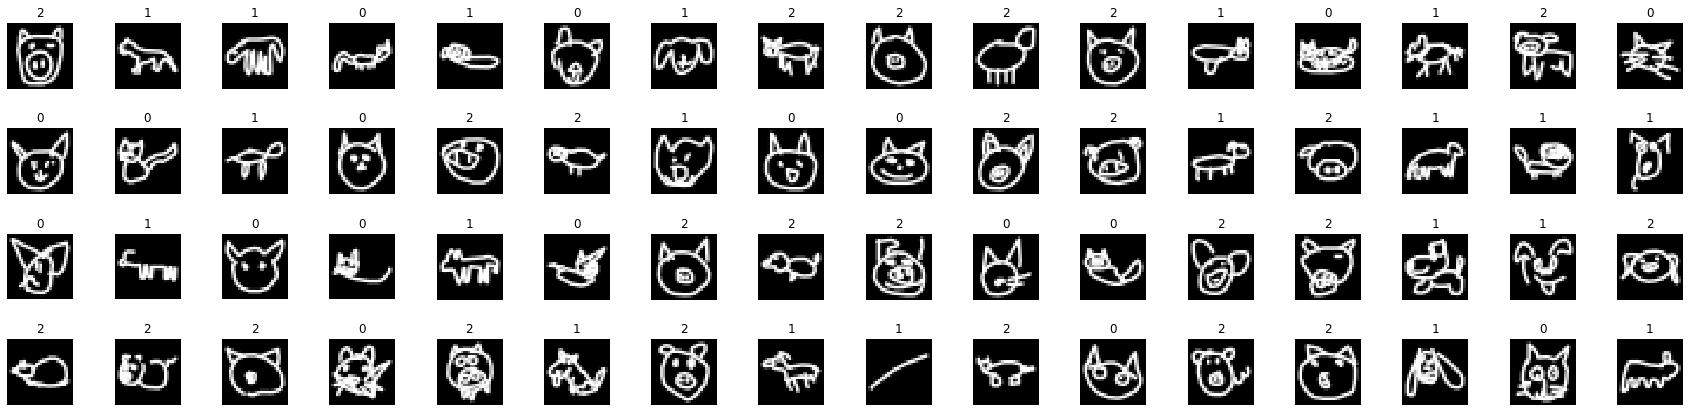

In [7]:
# Plot a few sketch examples
f, axarr = plt.subplots(4, 16, figsize=(24, 6))
f.tight_layout()

# Load a batch of images into memory
images, labels = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.title.set_text(labels[i].item())
    ax.axis('off')
    
plt.show()

# VAE

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# VAE Conv

In [0]:
ngf = 16
ndf = 16
nc = 1
h_dim=1024

class conv_VAE(nn.Module):
    def __init__(self, nz=32):
        super(conv_VAE, self).__init__()
        
        self.nz = nz
        
        self.encoder = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1024, 4, 1, 0, bias=False),
            # nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Sigmoid()
        )
        
        
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 1024, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     nc, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf),
            # nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            # nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            # nn.Tanh()
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc21 = nn.Linear(512, nz)
        self.fc22 = nn.Linear(512, nz)

        self.fc3 = nn.Linear(nz, 512)
        self.fc4 = nn.Linear(512, 1024)

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        conv = self.encoder(x);
        # print("encode conv", conv.size())
        h1 = self.fc1(conv.view(-1, 1024))
        # print("encode h1", h1.size())
        return self.fc21(h1), self.fc22(h1)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        deconv_input = self.fc4(h3)
        # print("deconv_input", deconv_input.size())
        deconv_input = deconv_input.view(-1,1024,1,1)
        # print("deconv_input", deconv_input.size())
        return self.decoder(deconv_input)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        # print("x", x.size())
        mu, logvar = self.encode(x)
        # print("mu, logvar", mu.size(), logvar.size())
        z = self.reparametrize(mu, logvar)
        # print("z", z.size())
        decoded = self.decode(z)
        # print("decoded", decoded.size())
        return decoded, mu, logvar

# Loss function

In [0]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl = -0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar), dim=1)

    return BCE + KLD, kl.mean()
    # return BCE + KLD, BCE, kl.mean()


# Train

In [0]:
def train(epoch):
    model.train()
    batch_loss, batch_kl = [],[]
    batch_idx = 0
    # batch_elbo = []

    for data, _ in train_loader:
        data = data.to(device)

        recon_batch, mu, logvar = model(data)
        loss, kld = loss_function(recon_batch, data, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item() / len(data)) # divide by batch_size to get average
        batch_kl.append(kld.item())

        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')   
        batch_idx = batch_idx + 1

    epoch_kl_train.append(np.mean(batch_kl))
    epoch_loss_train.append(np.mean(batch_loss))
    print(f'====> Epoch: {epoch} Average loss: {np.mean(batch_loss):.4f}')


# Test

In [0]:
def test(epoch):
    show_img = True
    datapath = os.path.join(root, 'results')
    if not os.path.exists(datapath):
        os.makedirs(datapath)
    
    model.eval()
    batch_loss, batch_kl = [],[]
    
    with torch.no_grad():
        for data, _ in test_loader: 
            data = data.to(device)

            recon_batch, mu, logvar = model(data)
            loss, kld = loss_function(recon_batch, data, mu, logvar)

            batch_loss.append(loss.item() / len(data))
            batch_kl.append(kld.item())
     
            recon_batch = recon_batch.to("cpu")

            if show_img:
                plot_all_images(data, recon_batch, 32)
                show_img = False

    epoch_kl_test.append(np.mean(batch_kl))
    epoch_loss_test.append(np.mean(batch_loss))
    print(f'====> Test set loss: {np.mean(batch_loss):.4f}')

# Plots

In [13]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import inset_axes

# Plots the input, reconstructions, and latent space samples for 
def plot_all_images(data, recon_batch, bottleneck_dim):

    f, axarr = plt.subplots(1, 3, figsize=(24, 8))
    rows = 8
    columns = batch_size // rows

    # -- Inputs -- 
    ax = axarr[0]
    ax.set_title('Inputs')
    ax.axis('off')

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = data[idx].cpu().reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    # -- Reconstructions -- 
    ax = axarr[1]
    ax.set_title('Reconstructions')
    ax.axis('off')

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = recon_batch[idx].cpu().reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    # -- Latent space samples --
    ax = axarr[2]
    ax.set_title('Latent Space Samples')
    ax.axis('off')

    with torch.no_grad():
        epsilon = torch.randn(64, bottleneck_dim).to(device)
        samples = model.decode(epsilon).cpu()

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = samples[idx].reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  


In [0]:
def plot_losses(epoch_list, train_loss_all, test_loss_all, kl_loss_train, kl_loss_test):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
    
    # ELBO loss
    ax1.set_title("ELBO loss")
    ax1.plot(epoch_list, train_loss_all, color="blue")
    ax1.plot(epoch_list, test_loss_all, color="green", linestyle="--")
    ax1.legend(['Training', 'Testing'])
    ax1.set(xlabel='epochs', ylabel='loss')

    # KL loss
    ax2.set_title("KL loss")
    ax2.plot(epoch_list, kl_loss_train, color="blue")
    ax2.plot(epoch_list, kl_loss_test, color="green", linestyle="--")
    ax2.legend(['Training', 'Testing'])
    ax2.set(xlabel='epochs', ylabel='loss')
    
    plt.show()

In [0]:

def plot_interpolated_images(images):

    f, axarr = plt.subplots(1, images.shape[0], figsize=(20, 5))
    f.tight_layout()

    for i, ax in enumerate(axarr.flat):
        ax.imshow(images[i].view(28, 28), cmap="binary_r")
        ax.axis('off')
    plt.show()

# Main

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([64, 784])) that is different to the input size (torch.Size([64, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  


Train Epoch: 1 [0/24000 (0%)]	Loss: 720.413330
Train Epoch: 1 [1024/24000 (4%)]	Loss: 371.010498
Train Epoch: 1 [2048/24000 (9%)]	Loss: 325.827332
Train Epoch: 1 [3072/24000 (13%)]	Loss: 310.473480
Train Epoch: 1 [4096/24000 (17%)]	Loss: 313.644531
Train Epoch: 1 [5120/24000 (21%)]	Loss: 308.646912
Train Epoch: 1 [6144/24000 (26%)]	Loss: 310.327942
Train Epoch: 1 [7168/24000 (30%)]	Loss: 302.919495
Train Epoch: 1 [8192/24000 (34%)]	Loss: 297.039368
Train Epoch: 1 [9216/24000 (38%)]	Loss: 292.715942
Train Epoch: 1 [10240/24000 (43%)]	Loss: 295.774963
Train Epoch: 1 [11264/24000 (47%)]	Loss: 310.935822
Train Epoch: 1 [12288/24000 (51%)]	Loss: 298.837189
Train Epoch: 1 [13312/24000 (55%)]	Loss: 282.770142
Train Epoch: 1 [14336/24000 (60%)]	Loss: 285.507965
Train Epoch: 1 [15360/24000 (64%)]	Loss: 276.321228
Train Epoch: 1 [16384/24000 (68%)]	Loss: 287.530243
Train Epoch: 1 [17408/24000 (73%)]	Loss: 265.245331
Train Epoch: 1 [18432/24000 (77%)]	Loss: 286.176697
Train Epoch: 1 [19456/24000 

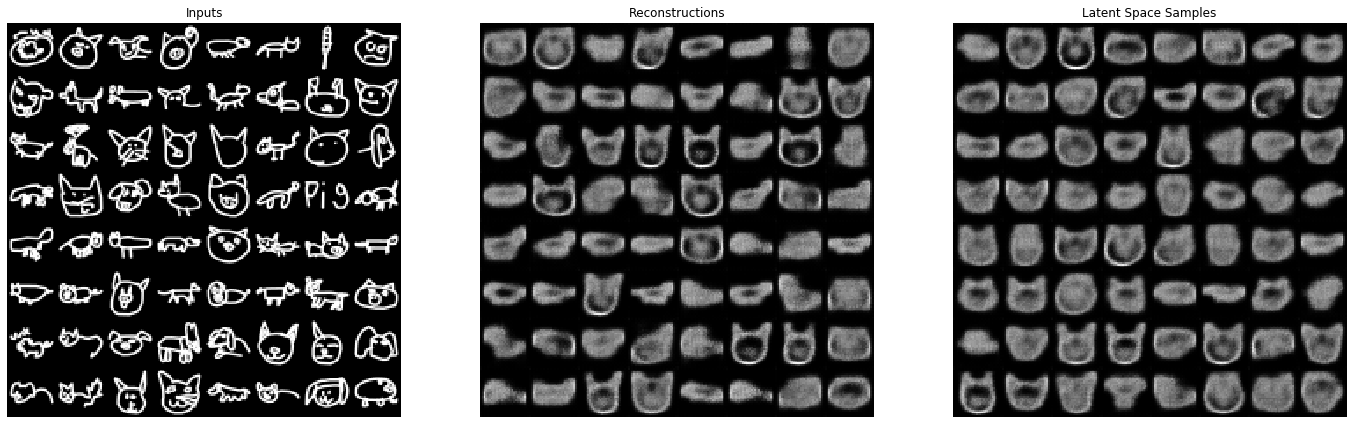

====> Test set loss: 264.4824
Train Epoch: 2 [0/24000 (0%)]	Loss: 263.164856
Train Epoch: 2 [1024/24000 (4%)]	Loss: 260.386139
Train Epoch: 2 [2048/24000 (9%)]	Loss: 265.309845
Train Epoch: 2 [3072/24000 (13%)]	Loss: 262.272736
Train Epoch: 2 [4096/24000 (17%)]	Loss: 261.209534
Train Epoch: 2 [5120/24000 (21%)]	Loss: 261.701324
Train Epoch: 2 [6144/24000 (26%)]	Loss: 255.799103
Train Epoch: 2 [7168/24000 (30%)]	Loss: 253.145782
Train Epoch: 2 [8192/24000 (34%)]	Loss: 254.775208
Train Epoch: 2 [9216/24000 (38%)]	Loss: 241.507538
Train Epoch: 2 [10240/24000 (43%)]	Loss: 251.071808
Train Epoch: 2 [11264/24000 (47%)]	Loss: 251.139404
Train Epoch: 2 [12288/24000 (51%)]	Loss: 250.678955
Train Epoch: 2 [13312/24000 (55%)]	Loss: 265.637146
Train Epoch: 2 [14336/24000 (60%)]	Loss: 250.430725
Train Epoch: 2 [15360/24000 (64%)]	Loss: 261.228424
Train Epoch: 2 [16384/24000 (68%)]	Loss: 255.052170
Train Epoch: 2 [17408/24000 (73%)]	Loss: 248.180252
Train Epoch: 2 [18432/24000 (77%)]	Loss: 252.10226

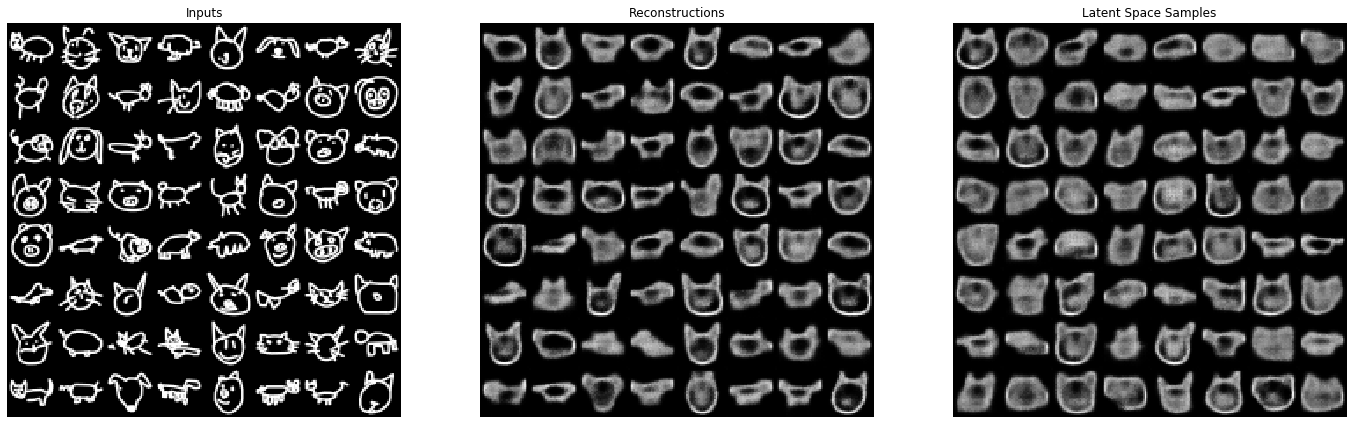

====> Test set loss: 246.4728


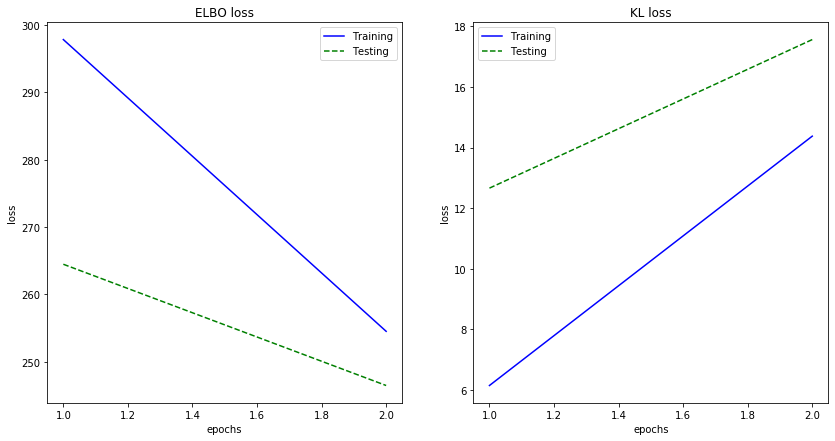

################################################################
Train Epoch: 3 [0/24000 (0%)]	Loss: 252.726898
Train Epoch: 3 [1024/24000 (4%)]	Loss: 252.157852
Train Epoch: 3 [2048/24000 (9%)]	Loss: 231.333084
Train Epoch: 3 [3072/24000 (13%)]	Loss: 250.757080
Train Epoch: 3 [4096/24000 (17%)]	Loss: 246.483307
Train Epoch: 3 [5120/24000 (21%)]	Loss: 242.404312
Train Epoch: 3 [6144/24000 (26%)]	Loss: 245.289200
Train Epoch: 3 [7168/24000 (30%)]	Loss: 246.962646
Train Epoch: 3 [8192/24000 (34%)]	Loss: 254.425842
Train Epoch: 3 [9216/24000 (38%)]	Loss: 238.180954
Train Epoch: 3 [10240/24000 (43%)]	Loss: 232.243774
Train Epoch: 3 [11264/24000 (47%)]	Loss: 243.694946
Train Epoch: 3 [12288/24000 (51%)]	Loss: 250.330414
Train Epoch: 3 [13312/24000 (55%)]	Loss: 256.370972
Train Epoch: 3 [14336/24000 (60%)]	Loss: 242.273849
Train Epoch: 3 [15360/24000 (64%)]	Loss: 232.322113
Train Epoch: 3 [16384/24000 (68%)]	Loss: 249.261826
Train Epoch: 3 [17408/24000 (73%)]	Loss: 240.394775
Train Epoch: 3 

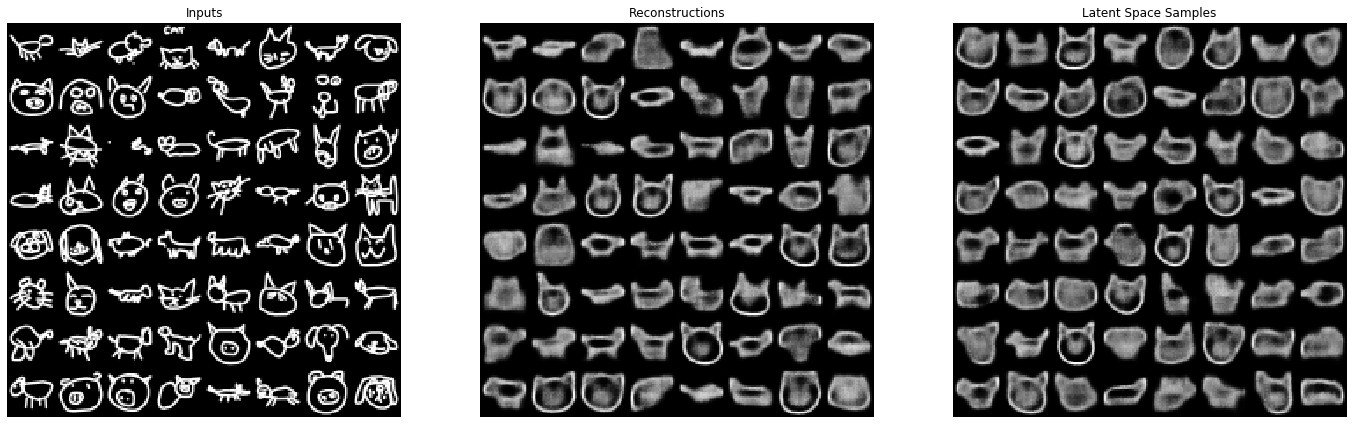

====> Test set loss: 237.4003


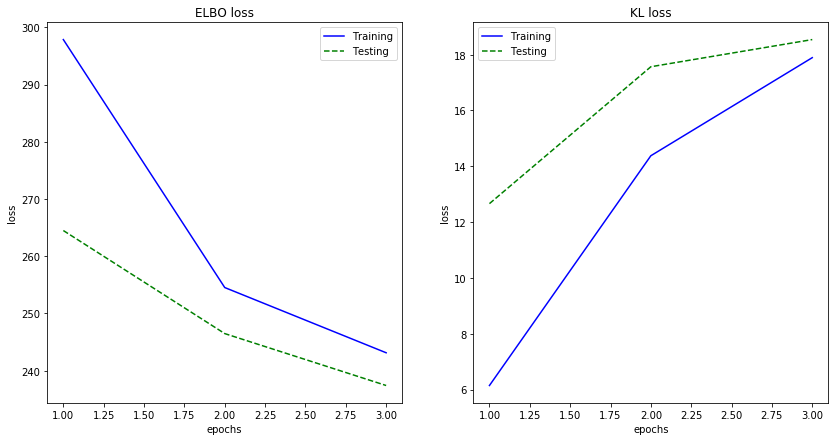

################################################################
Train Epoch: 4 [0/24000 (0%)]	Loss: 225.237152
Train Epoch: 4 [1024/24000 (4%)]	Loss: 230.371002
Train Epoch: 4 [2048/24000 (9%)]	Loss: 241.979736
Train Epoch: 4 [3072/24000 (13%)]	Loss: 248.415955
Train Epoch: 4 [4096/24000 (17%)]	Loss: 235.166840
Train Epoch: 4 [5120/24000 (21%)]	Loss: 235.325577
Train Epoch: 4 [6144/24000 (26%)]	Loss: 232.497162
Train Epoch: 4 [7168/24000 (30%)]	Loss: 235.850250
Train Epoch: 4 [8192/24000 (34%)]	Loss: 247.556671
Train Epoch: 4 [9216/24000 (38%)]	Loss: 237.387848
Train Epoch: 4 [10240/24000 (43%)]	Loss: 225.481049
Train Epoch: 4 [11264/24000 (47%)]	Loss: 237.181000
Train Epoch: 4 [12288/24000 (51%)]	Loss: 236.187439
Train Epoch: 4 [13312/24000 (55%)]	Loss: 230.830399
Train Epoch: 4 [14336/24000 (60%)]	Loss: 233.741791
Train Epoch: 4 [15360/24000 (64%)]	Loss: 238.989914
Train Epoch: 4 [16384/24000 (68%)]	Loss: 226.105316
Train Epoch: 4 [17408/24000 (73%)]	Loss: 249.691467
Train Epoch: 4 

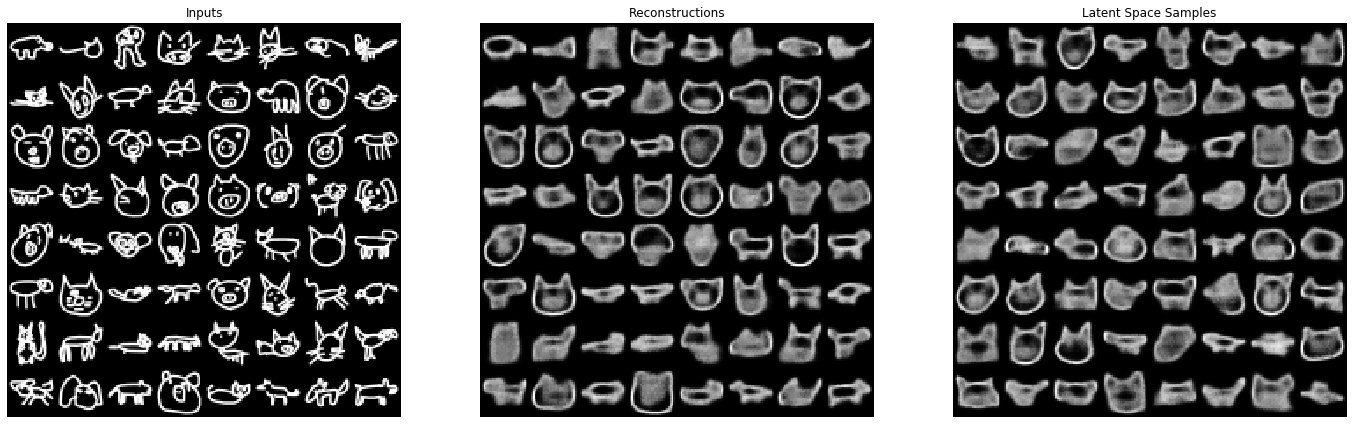

====> Test set loss: 234.9532


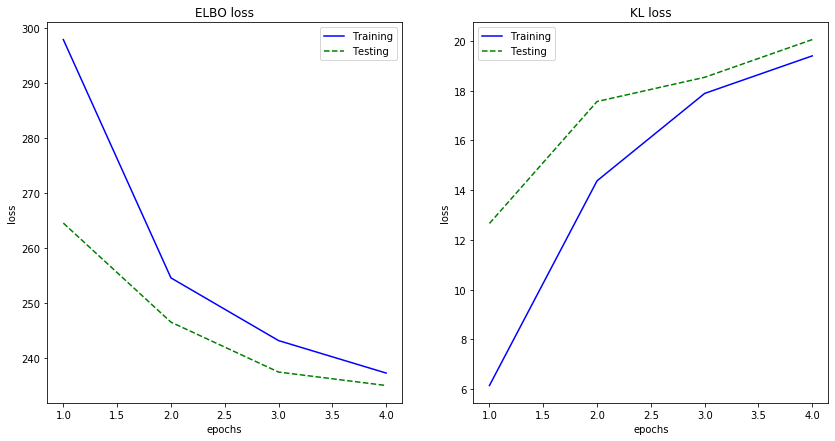

################################################################
Train Epoch: 5 [0/24000 (0%)]	Loss: 233.669708
Train Epoch: 5 [1024/24000 (4%)]	Loss: 237.446686
Train Epoch: 5 [2048/24000 (9%)]	Loss: 232.190659
Train Epoch: 5 [3072/24000 (13%)]	Loss: 248.568970
Train Epoch: 5 [4096/24000 (17%)]	Loss: 237.009903
Train Epoch: 5 [5120/24000 (21%)]	Loss: 236.879578
Train Epoch: 5 [6144/24000 (26%)]	Loss: 230.128418
Train Epoch: 5 [7168/24000 (30%)]	Loss: 231.204376
Train Epoch: 5 [8192/24000 (34%)]	Loss: 236.574402
Train Epoch: 5 [9216/24000 (38%)]	Loss: 227.054489
Train Epoch: 5 [10240/24000 (43%)]	Loss: 245.041611
Train Epoch: 5 [11264/24000 (47%)]	Loss: 242.093338
Train Epoch: 5 [12288/24000 (51%)]	Loss: 226.688904
Train Epoch: 5 [13312/24000 (55%)]	Loss: 234.836990
Train Epoch: 5 [14336/24000 (60%)]	Loss: 236.454102
Train Epoch: 5 [15360/24000 (64%)]	Loss: 224.645416
Train Epoch: 5 [16384/24000 (68%)]	Loss: 231.774261
Train Epoch: 5 [17408/24000 (73%)]	Loss: 235.277405
Train Epoch: 5 

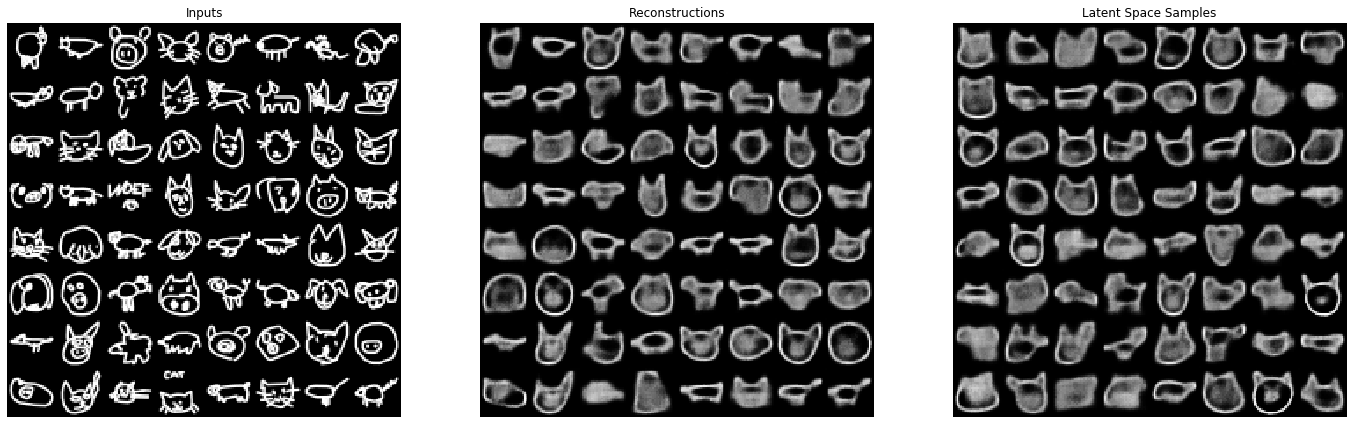

====> Test set loss: 232.7951


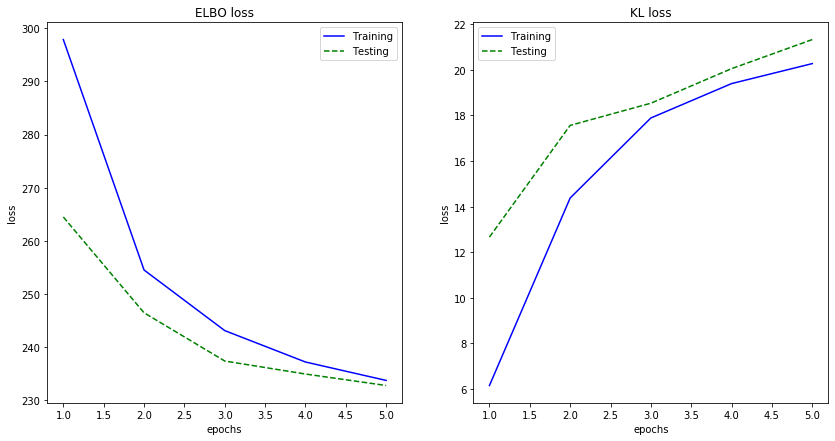

################################################################
Train Epoch: 6 [0/24000 (0%)]	Loss: 247.461945
Train Epoch: 6 [1024/24000 (4%)]	Loss: 228.073227
Train Epoch: 6 [2048/24000 (9%)]	Loss: 231.593857
Train Epoch: 6 [3072/24000 (13%)]	Loss: 231.102524
Train Epoch: 6 [4096/24000 (17%)]	Loss: 239.806427
Train Epoch: 6 [5120/24000 (21%)]	Loss: 225.125641
Train Epoch: 6 [6144/24000 (26%)]	Loss: 229.417709
Train Epoch: 6 [7168/24000 (30%)]	Loss: 221.513916
Train Epoch: 6 [8192/24000 (34%)]	Loss: 233.715149
Train Epoch: 6 [9216/24000 (38%)]	Loss: 226.345596
Train Epoch: 6 [10240/24000 (43%)]	Loss: 232.811554
Train Epoch: 6 [11264/24000 (47%)]	Loss: 230.153229
Train Epoch: 6 [12288/24000 (51%)]	Loss: 228.327667
Train Epoch: 6 [13312/24000 (55%)]	Loss: 232.783966
Train Epoch: 6 [14336/24000 (60%)]	Loss: 231.454575
Train Epoch: 6 [15360/24000 (64%)]	Loss: 233.583054
Train Epoch: 6 [16384/24000 (68%)]	Loss: 245.769547
Train Epoch: 6 [17408/24000 (73%)]	Loss: 231.616058
Train Epoch: 6 

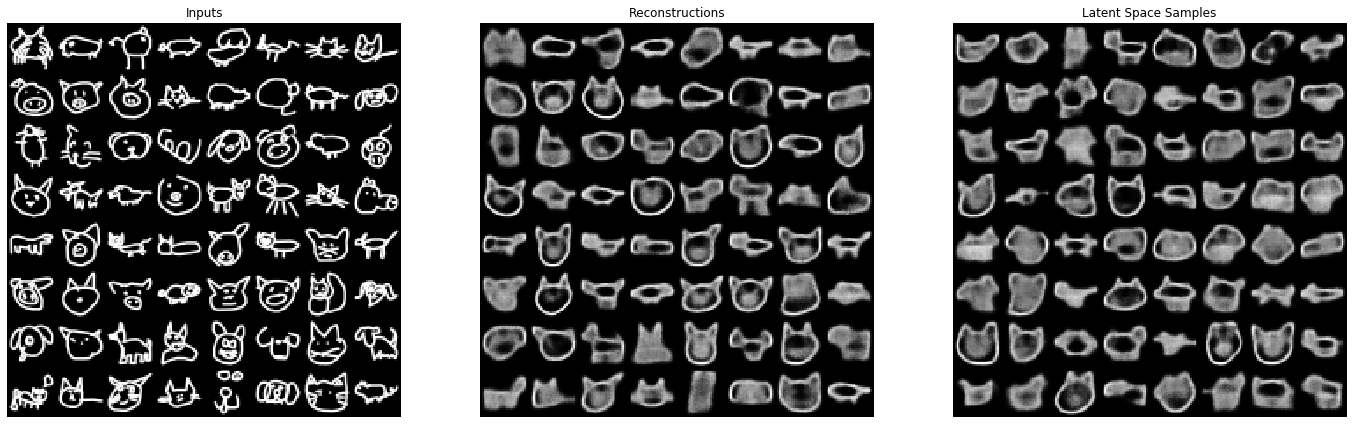

====> Test set loss: 230.9610


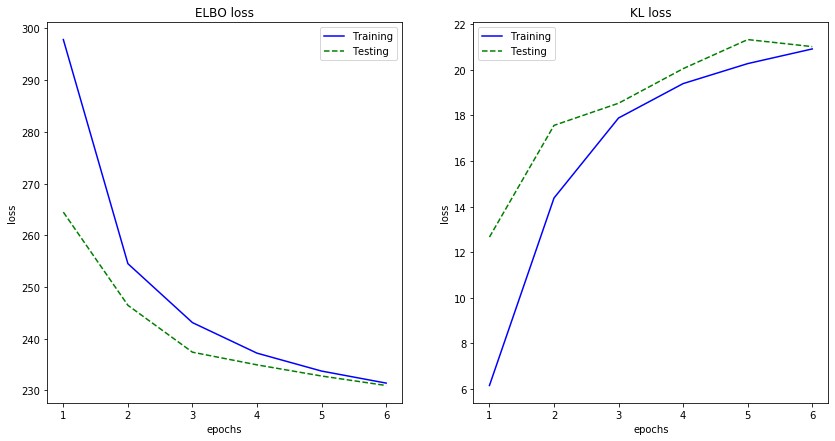

################################################################
Train Epoch: 7 [0/24000 (0%)]	Loss: 230.789932
Train Epoch: 7 [1024/24000 (4%)]	Loss: 230.078339
Train Epoch: 7 [2048/24000 (9%)]	Loss: 226.741119
Train Epoch: 7 [3072/24000 (13%)]	Loss: 231.127960
Train Epoch: 7 [4096/24000 (17%)]	Loss: 229.758621
Train Epoch: 7 [5120/24000 (21%)]	Loss: 219.369644
Train Epoch: 7 [6144/24000 (26%)]	Loss: 218.403534
Train Epoch: 7 [7168/24000 (30%)]	Loss: 231.091156
Train Epoch: 7 [8192/24000 (34%)]	Loss: 230.558975
Train Epoch: 7 [9216/24000 (38%)]	Loss: 229.272034
Train Epoch: 7 [10240/24000 (43%)]	Loss: 226.810638
Train Epoch: 7 [11264/24000 (47%)]	Loss: 236.768127
Train Epoch: 7 [12288/24000 (51%)]	Loss: 222.151031
Train Epoch: 7 [13312/24000 (55%)]	Loss: 228.924896
Train Epoch: 7 [14336/24000 (60%)]	Loss: 228.582932
Train Epoch: 7 [15360/24000 (64%)]	Loss: 228.775955
Train Epoch: 7 [16384/24000 (68%)]	Loss: 230.824432
Train Epoch: 7 [17408/24000 (73%)]	Loss: 232.262024
Train Epoch: 7 

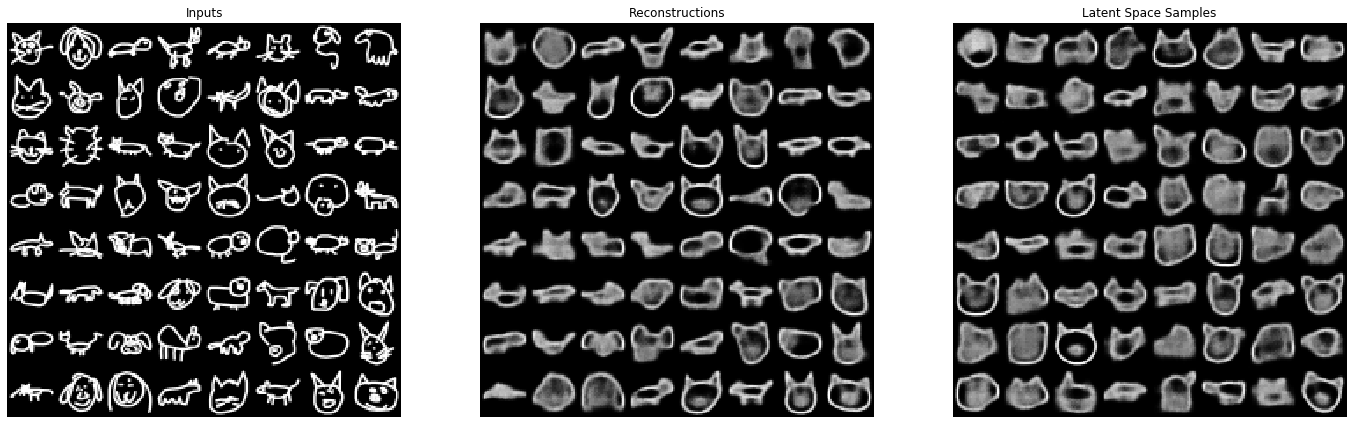

====> Test set loss: 228.8826


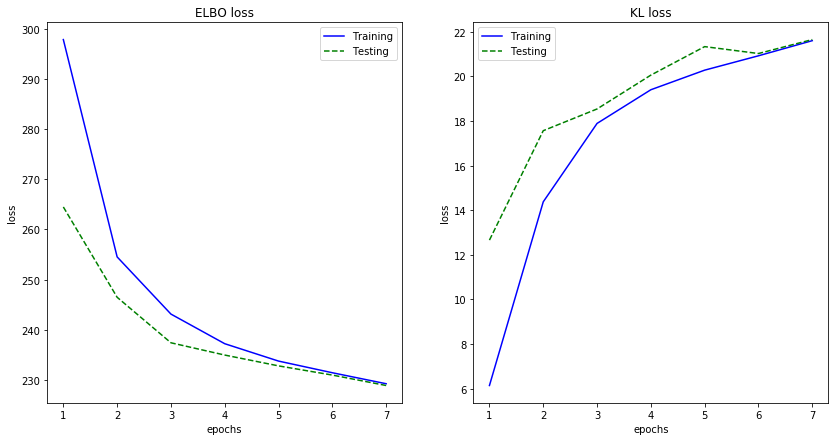

################################################################
Train Epoch: 8 [0/24000 (0%)]	Loss: 236.448471
Train Epoch: 8 [1024/24000 (4%)]	Loss: 238.185715
Train Epoch: 8 [2048/24000 (9%)]	Loss: 218.694672
Train Epoch: 8 [3072/24000 (13%)]	Loss: 225.190796
Train Epoch: 8 [4096/24000 (17%)]	Loss: 232.443359
Train Epoch: 8 [5120/24000 (21%)]	Loss: 222.529617
Train Epoch: 8 [6144/24000 (26%)]	Loss: 228.279770
Train Epoch: 8 [7168/24000 (30%)]	Loss: 238.568817
Train Epoch: 8 [8192/24000 (34%)]	Loss: 222.481750
Train Epoch: 8 [9216/24000 (38%)]	Loss: 218.662674
Train Epoch: 8 [10240/24000 (43%)]	Loss: 218.383240
Train Epoch: 8 [11264/24000 (47%)]	Loss: 230.273026
Train Epoch: 8 [12288/24000 (51%)]	Loss: 226.720016
Train Epoch: 8 [13312/24000 (55%)]	Loss: 232.038406
Train Epoch: 8 [14336/24000 (60%)]	Loss: 233.916580
Train Epoch: 8 [15360/24000 (64%)]	Loss: 228.075775
Train Epoch: 8 [16384/24000 (68%)]	Loss: 219.711761
Train Epoch: 8 [17408/24000 (73%)]	Loss: 230.875885
Train Epoch: 8 

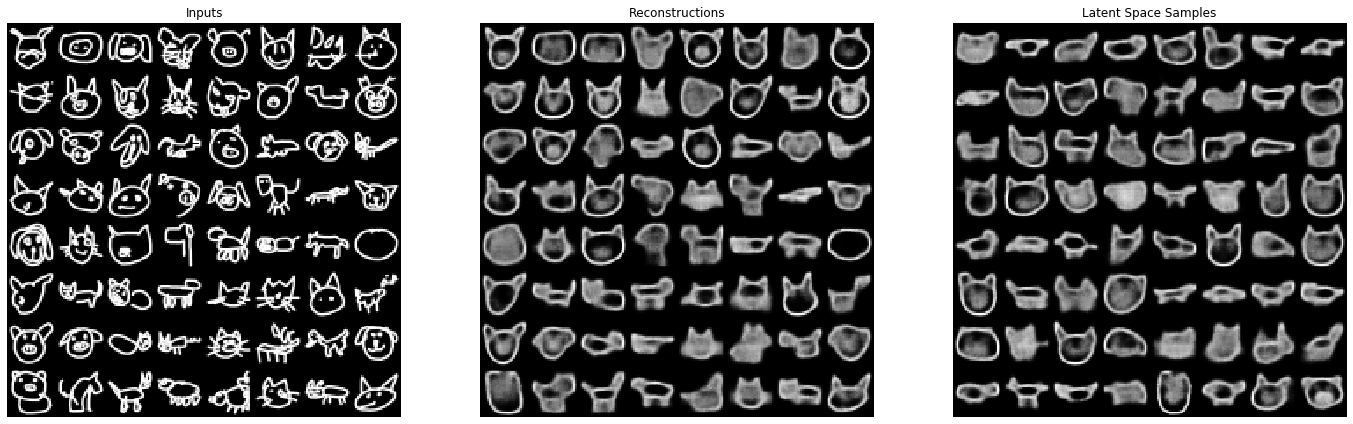

====> Test set loss: 228.2601


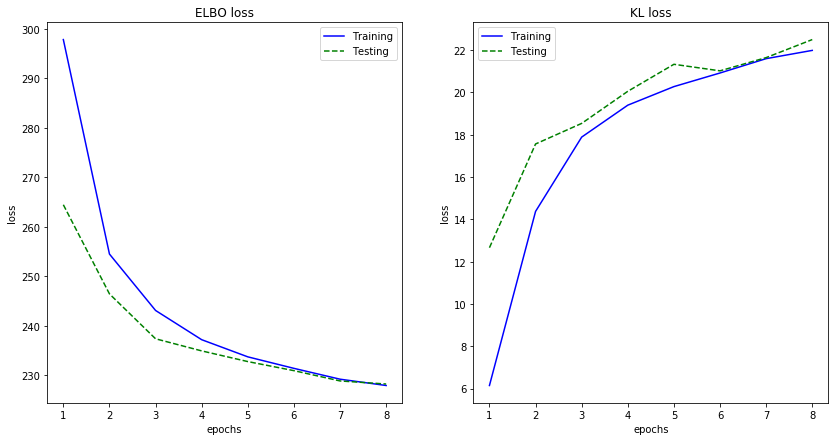

################################################################
Train Epoch: 9 [0/24000 (0%)]	Loss: 231.682083
Train Epoch: 9 [1024/24000 (4%)]	Loss: 230.952057
Train Epoch: 9 [2048/24000 (9%)]	Loss: 219.309296
Train Epoch: 9 [3072/24000 (13%)]	Loss: 229.736343
Train Epoch: 9 [4096/24000 (17%)]	Loss: 225.503235
Train Epoch: 9 [5120/24000 (21%)]	Loss: 215.531982
Train Epoch: 9 [6144/24000 (26%)]	Loss: 214.634048
Train Epoch: 9 [7168/24000 (30%)]	Loss: 224.302765
Train Epoch: 9 [8192/24000 (34%)]	Loss: 219.175232
Train Epoch: 9 [9216/24000 (38%)]	Loss: 220.344070
Train Epoch: 9 [10240/24000 (43%)]	Loss: 231.987091
Train Epoch: 9 [11264/24000 (47%)]	Loss: 217.049057
Train Epoch: 9 [12288/24000 (51%)]	Loss: 226.966232
Train Epoch: 9 [13312/24000 (55%)]	Loss: 220.371552
Train Epoch: 9 [14336/24000 (60%)]	Loss: 243.782104
Train Epoch: 9 [15360/24000 (64%)]	Loss: 233.411911
Train Epoch: 9 [16384/24000 (68%)]	Loss: 231.613983
Train Epoch: 9 [17408/24000 (73%)]	Loss: 215.233124
Train Epoch: 9 

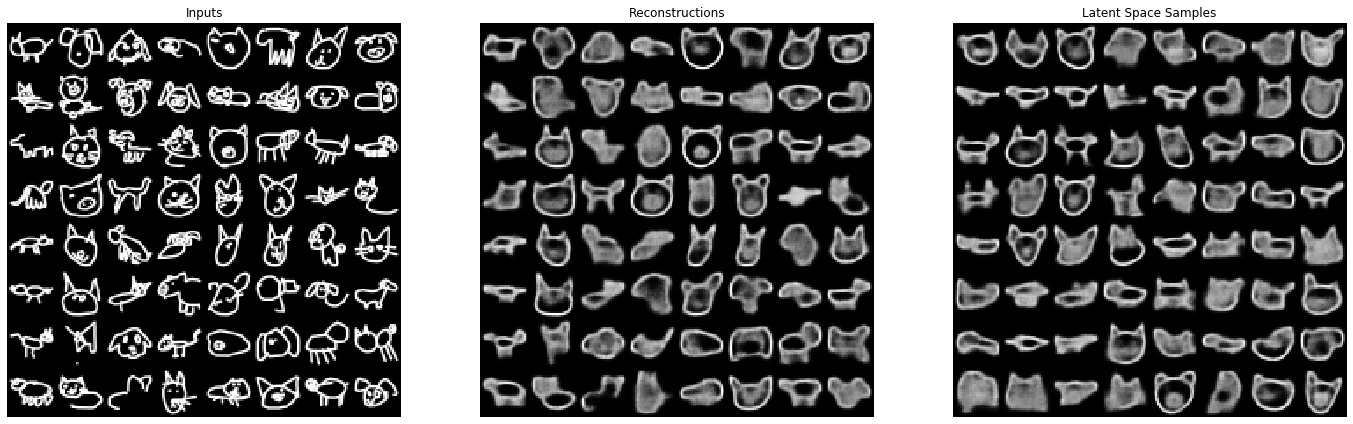

====> Test set loss: 226.2292


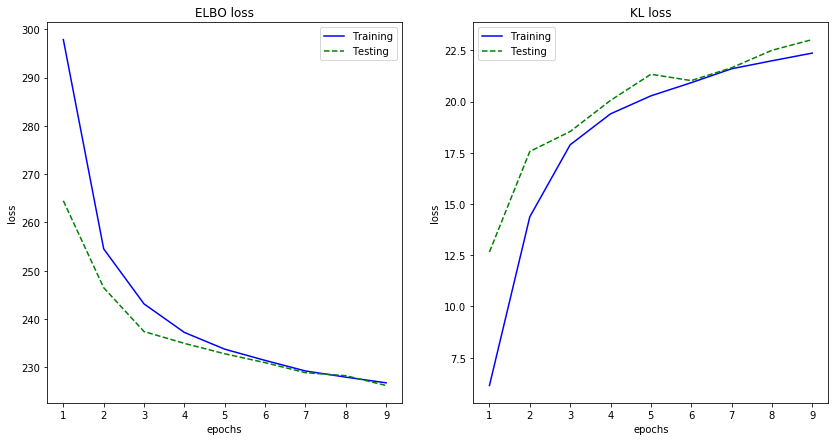

################################################################
Train Epoch: 10 [0/24000 (0%)]	Loss: 212.675766
Train Epoch: 10 [1024/24000 (4%)]	Loss: 235.479263
Train Epoch: 10 [2048/24000 (9%)]	Loss: 212.498474
Train Epoch: 10 [3072/24000 (13%)]	Loss: 223.450806
Train Epoch: 10 [4096/24000 (17%)]	Loss: 230.769287
Train Epoch: 10 [5120/24000 (21%)]	Loss: 225.272964
Train Epoch: 10 [6144/24000 (26%)]	Loss: 226.159561
Train Epoch: 10 [7168/24000 (30%)]	Loss: 221.679001
Train Epoch: 10 [8192/24000 (34%)]	Loss: 216.135345
Train Epoch: 10 [9216/24000 (38%)]	Loss: 217.457550
Train Epoch: 10 [10240/24000 (43%)]	Loss: 234.027695
Train Epoch: 10 [11264/24000 (47%)]	Loss: 230.183090
Train Epoch: 10 [12288/24000 (51%)]	Loss: 225.538361
Train Epoch: 10 [13312/24000 (55%)]	Loss: 218.098816
Train Epoch: 10 [14336/24000 (60%)]	Loss: 217.656998
Train Epoch: 10 [15360/24000 (64%)]	Loss: 222.041138
Train Epoch: 10 [16384/24000 (68%)]	Loss: 226.336304
Train Epoch: 10 [17408/24000 (73%)]	Loss: 223.6371

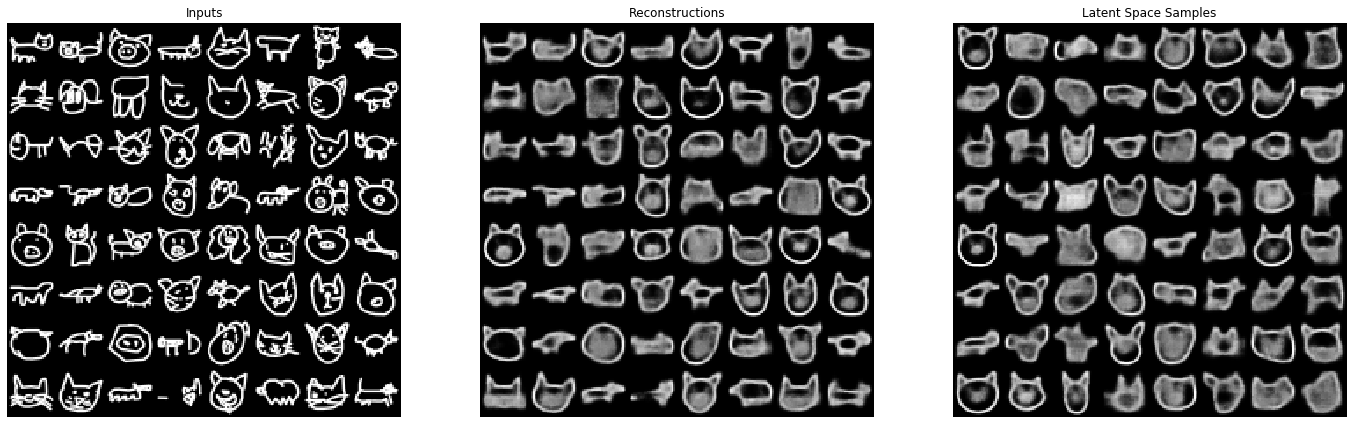

====> Test set loss: 225.7663


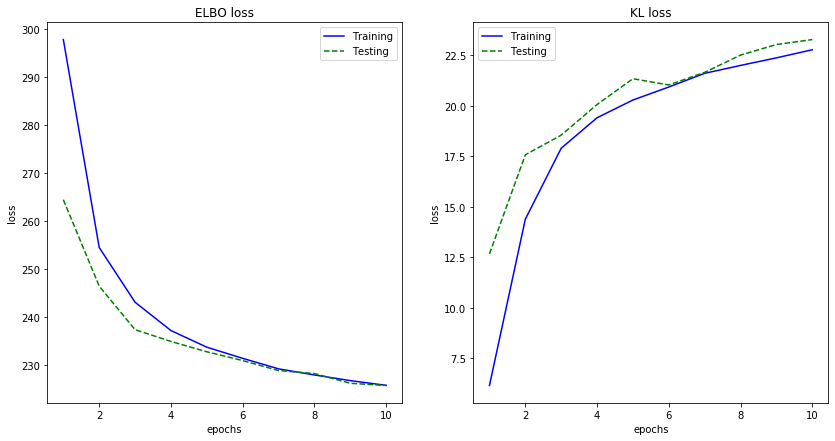

################################################################
Train Epoch: 11 [0/24000 (0%)]	Loss: 227.303986
Train Epoch: 11 [1024/24000 (4%)]	Loss: 222.197952
Train Epoch: 11 [2048/24000 (9%)]	Loss: 226.569809
Train Epoch: 11 [3072/24000 (13%)]	Loss: 223.974274
Train Epoch: 11 [4096/24000 (17%)]	Loss: 225.899612
Train Epoch: 11 [5120/24000 (21%)]	Loss: 215.057526
Train Epoch: 11 [6144/24000 (26%)]	Loss: 216.751495
Train Epoch: 11 [7168/24000 (30%)]	Loss: 228.143066
Train Epoch: 11 [8192/24000 (34%)]	Loss: 226.724884
Train Epoch: 11 [9216/24000 (38%)]	Loss: 214.675308
Train Epoch: 11 [10240/24000 (43%)]	Loss: 224.718552
Train Epoch: 11 [11264/24000 (47%)]	Loss: 238.038239
Train Epoch: 11 [12288/24000 (51%)]	Loss: 231.451263
Train Epoch: 11 [13312/24000 (55%)]	Loss: 229.848724
Train Epoch: 11 [14336/24000 (60%)]	Loss: 236.907471
Train Epoch: 11 [15360/24000 (64%)]	Loss: 213.511276
Train Epoch: 11 [16384/24000 (68%)]	Loss: 230.798508
Train Epoch: 11 [17408/24000 (73%)]	Loss: 220.2126

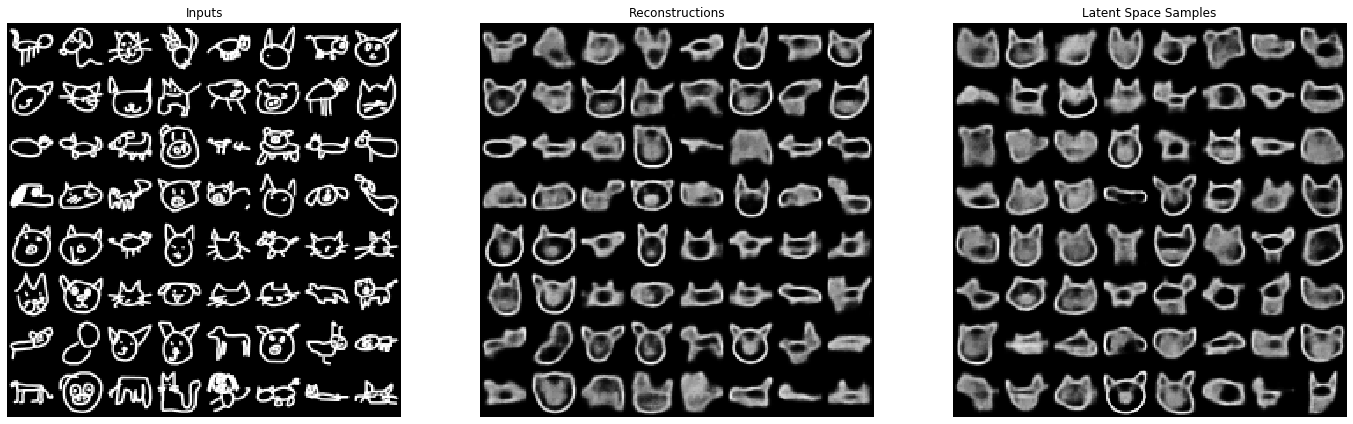

====> Test set loss: 225.4778


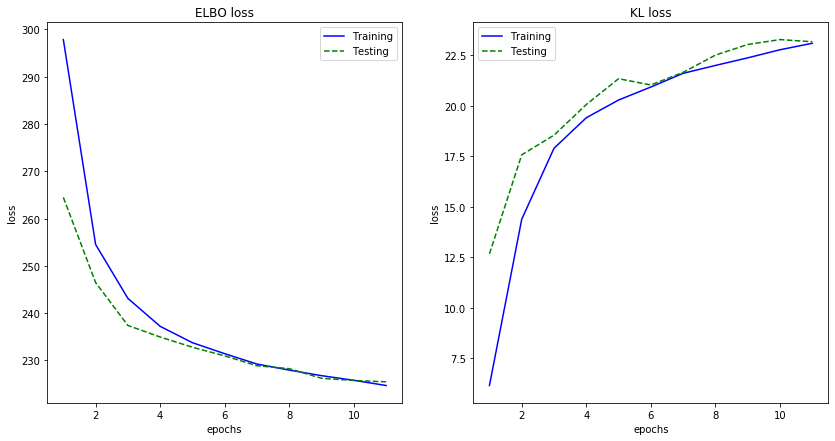

################################################################
Train Epoch: 12 [0/24000 (0%)]	Loss: 223.813507
Train Epoch: 12 [1024/24000 (4%)]	Loss: 223.519424
Train Epoch: 12 [2048/24000 (9%)]	Loss: 220.889313
Train Epoch: 12 [3072/24000 (13%)]	Loss: 212.480270
Train Epoch: 12 [4096/24000 (17%)]	Loss: 214.240448
Train Epoch: 12 [5120/24000 (21%)]	Loss: 225.297302
Train Epoch: 12 [6144/24000 (26%)]	Loss: 242.633896
Train Epoch: 12 [7168/24000 (30%)]	Loss: 226.782211
Train Epoch: 12 [8192/24000 (34%)]	Loss: 224.169128
Train Epoch: 12 [9216/24000 (38%)]	Loss: 218.324905
Train Epoch: 12 [10240/24000 (43%)]	Loss: 217.488312
Train Epoch: 12 [11264/24000 (47%)]	Loss: 208.981003
Train Epoch: 12 [12288/24000 (51%)]	Loss: 229.351212
Train Epoch: 12 [13312/24000 (55%)]	Loss: 231.190903
Train Epoch: 12 [14336/24000 (60%)]	Loss: 228.578751
Train Epoch: 12 [15360/24000 (64%)]	Loss: 212.639572
Train Epoch: 12 [16384/24000 (68%)]	Loss: 232.625763
Train Epoch: 12 [17408/24000 (73%)]	Loss: 241.3331

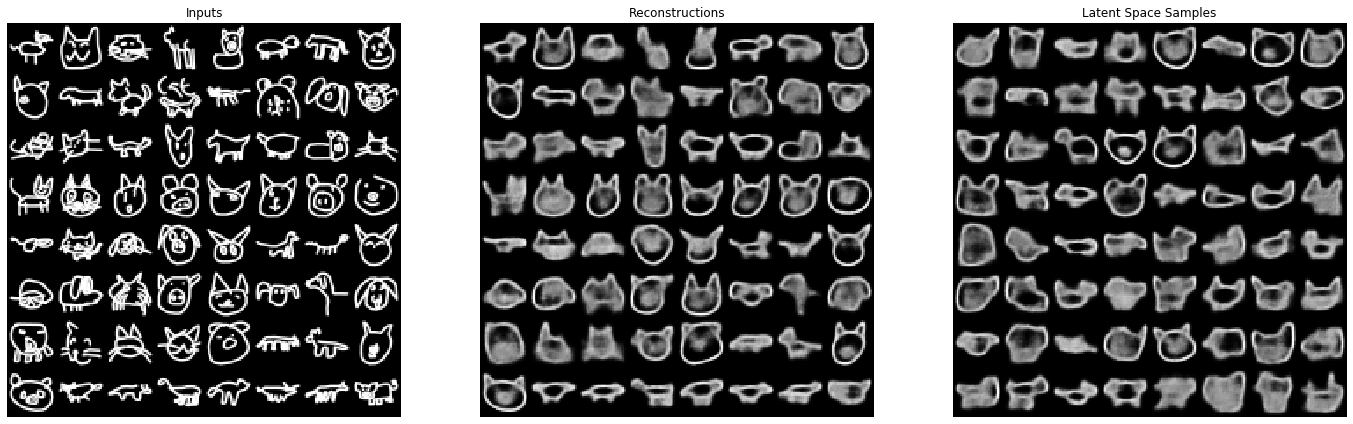

====> Test set loss: 224.7479


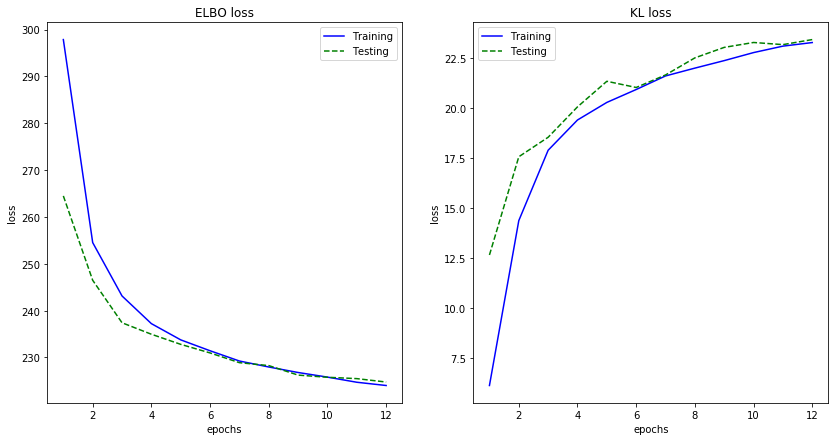

################################################################
Train Epoch: 13 [0/24000 (0%)]	Loss: 224.242920
Train Epoch: 13 [1024/24000 (4%)]	Loss: 220.710129
Train Epoch: 13 [2048/24000 (9%)]	Loss: 213.538910
Train Epoch: 13 [3072/24000 (13%)]	Loss: 230.811462
Train Epoch: 13 [4096/24000 (17%)]	Loss: 217.266006
Train Epoch: 13 [5120/24000 (21%)]	Loss: 227.063232
Train Epoch: 13 [6144/24000 (26%)]	Loss: 232.153381
Train Epoch: 13 [7168/24000 (30%)]	Loss: 223.775574
Train Epoch: 13 [8192/24000 (34%)]	Loss: 215.007782
Train Epoch: 13 [9216/24000 (38%)]	Loss: 234.614990
Train Epoch: 13 [10240/24000 (43%)]	Loss: 219.628143
Train Epoch: 13 [11264/24000 (47%)]	Loss: 218.967667
Train Epoch: 13 [12288/24000 (51%)]	Loss: 213.282562
Train Epoch: 13 [13312/24000 (55%)]	Loss: 233.799118
Train Epoch: 13 [14336/24000 (60%)]	Loss: 220.092300
Train Epoch: 13 [15360/24000 (64%)]	Loss: 216.580795
Train Epoch: 13 [16384/24000 (68%)]	Loss: 226.409042
Train Epoch: 13 [17408/24000 (73%)]	Loss: 224.3514

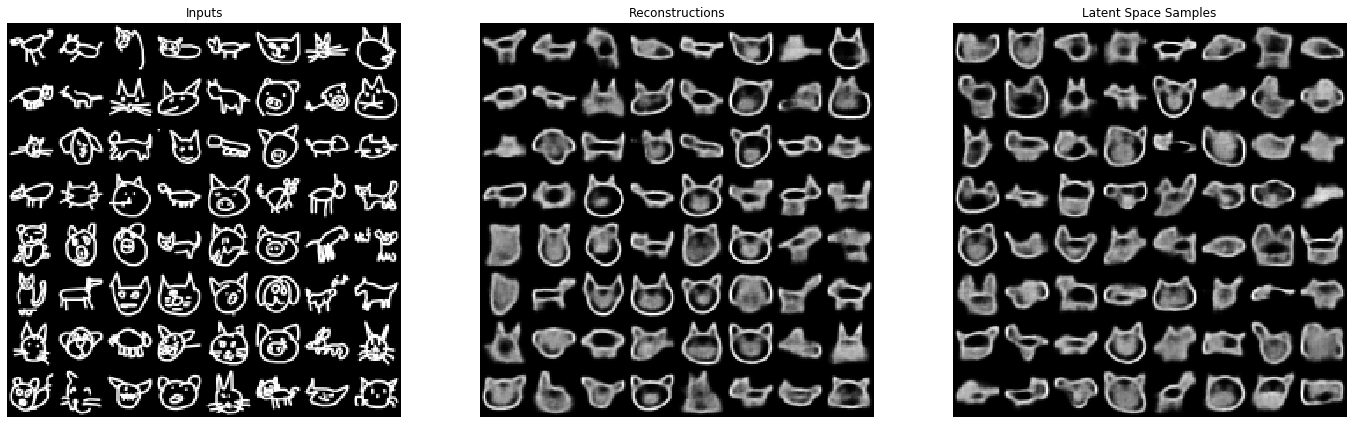

====> Test set loss: 224.2071


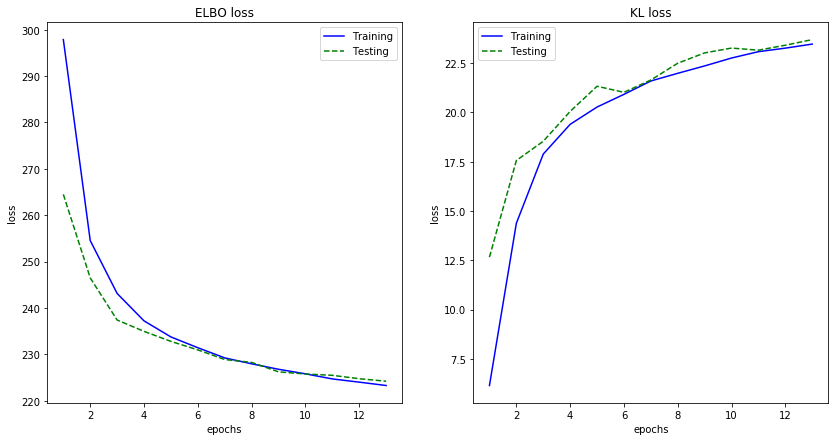

################################################################
Train Epoch: 14 [0/24000 (0%)]	Loss: 214.056305
Train Epoch: 14 [1024/24000 (4%)]	Loss: 221.691879
Train Epoch: 14 [2048/24000 (9%)]	Loss: 222.183640
Train Epoch: 14 [3072/24000 (13%)]	Loss: 215.891296
Train Epoch: 14 [4096/24000 (17%)]	Loss: 225.169907
Train Epoch: 14 [5120/24000 (21%)]	Loss: 230.137772
Train Epoch: 14 [6144/24000 (26%)]	Loss: 225.130829
Train Epoch: 14 [7168/24000 (30%)]	Loss: 227.561691
Train Epoch: 14 [8192/24000 (34%)]	Loss: 221.388885
Train Epoch: 14 [9216/24000 (38%)]	Loss: 214.714050
Train Epoch: 14 [10240/24000 (43%)]	Loss: 220.256500
Train Epoch: 14 [11264/24000 (47%)]	Loss: 216.247879
Train Epoch: 14 [12288/24000 (51%)]	Loss: 216.427002
Train Epoch: 14 [13312/24000 (55%)]	Loss: 217.408813
Train Epoch: 14 [14336/24000 (60%)]	Loss: 214.227219
Train Epoch: 14 [15360/24000 (64%)]	Loss: 224.330719
Train Epoch: 14 [16384/24000 (68%)]	Loss: 215.640778
Train Epoch: 14 [17408/24000 (73%)]	Loss: 222.8325

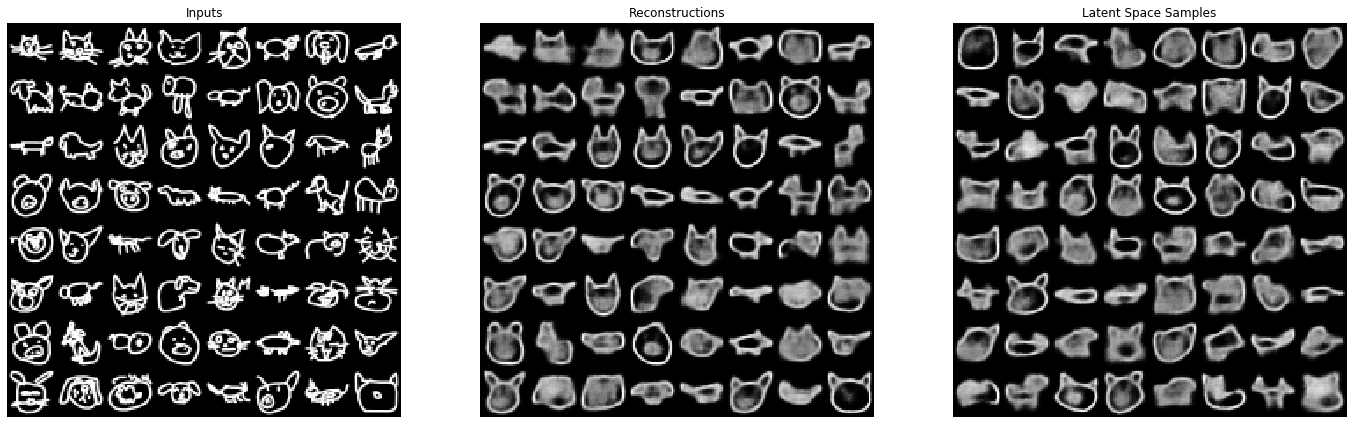

====> Test set loss: 223.5810


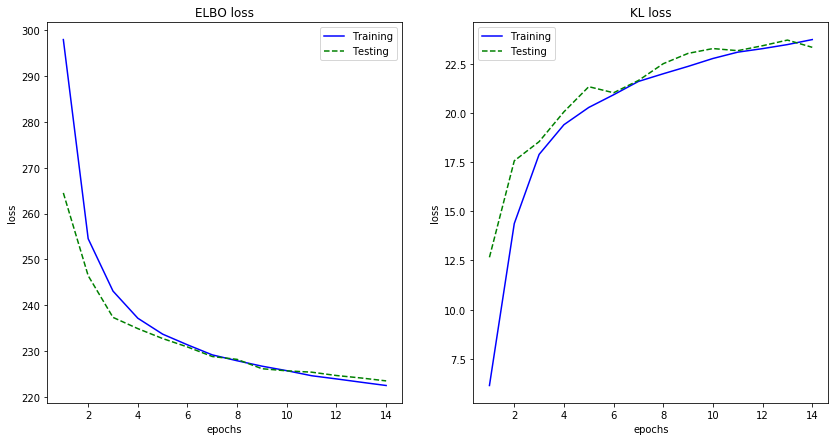

################################################################
Train Epoch: 15 [0/24000 (0%)]	Loss: 218.673172
Train Epoch: 15 [1024/24000 (4%)]	Loss: 215.566391
Train Epoch: 15 [2048/24000 (9%)]	Loss: 218.396393
Train Epoch: 15 [3072/24000 (13%)]	Loss: 217.090973
Train Epoch: 15 [4096/24000 (17%)]	Loss: 225.199539
Train Epoch: 15 [5120/24000 (21%)]	Loss: 223.099518
Train Epoch: 15 [6144/24000 (26%)]	Loss: 238.459000
Train Epoch: 15 [7168/24000 (30%)]	Loss: 216.212524
Train Epoch: 15 [8192/24000 (34%)]	Loss: 219.692337
Train Epoch: 15 [9216/24000 (38%)]	Loss: 220.460037
Train Epoch: 15 [10240/24000 (43%)]	Loss: 218.019623
Train Epoch: 15 [11264/24000 (47%)]	Loss: 225.484146
Train Epoch: 15 [12288/24000 (51%)]	Loss: 209.643158
Train Epoch: 15 [13312/24000 (55%)]	Loss: 221.615005
Train Epoch: 15 [14336/24000 (60%)]	Loss: 223.973450
Train Epoch: 15 [15360/24000 (64%)]	Loss: 230.825287
Train Epoch: 15 [16384/24000 (68%)]	Loss: 218.131378
Train Epoch: 15 [17408/24000 (73%)]	Loss: 227.7755

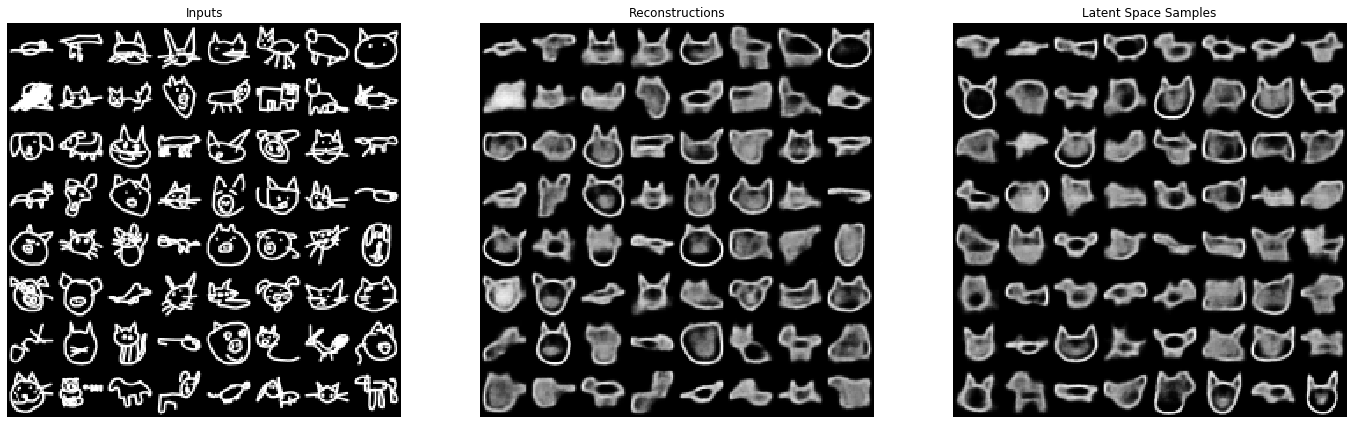

====> Test set loss: 222.5150


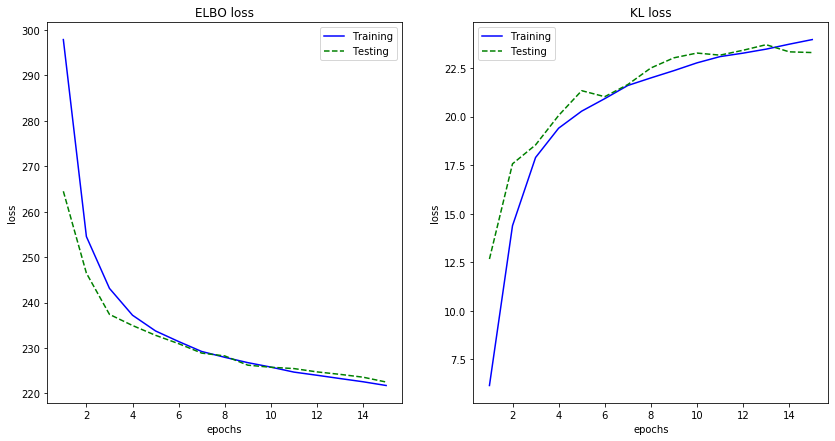

################################################################
Train Epoch: 16 [0/24000 (0%)]	Loss: 225.985992
Train Epoch: 16 [1024/24000 (4%)]	Loss: 219.505341
Train Epoch: 16 [2048/24000 (9%)]	Loss: 217.049866
Train Epoch: 16 [3072/24000 (13%)]	Loss: 219.529129
Train Epoch: 16 [4096/24000 (17%)]	Loss: 228.589264
Train Epoch: 16 [5120/24000 (21%)]	Loss: 225.819748
Train Epoch: 16 [6144/24000 (26%)]	Loss: 229.370331
Train Epoch: 16 [7168/24000 (30%)]	Loss: 214.201431
Train Epoch: 16 [8192/24000 (34%)]	Loss: 219.902710
Train Epoch: 16 [9216/24000 (38%)]	Loss: 214.049957
Train Epoch: 16 [10240/24000 (43%)]	Loss: 221.579605
Train Epoch: 16 [11264/24000 (47%)]	Loss: 219.888550
Train Epoch: 16 [12288/24000 (51%)]	Loss: 208.524338
Train Epoch: 16 [13312/24000 (55%)]	Loss: 219.364822
Train Epoch: 16 [14336/24000 (60%)]	Loss: 226.887924
Train Epoch: 16 [15360/24000 (64%)]	Loss: 224.825699
Train Epoch: 16 [16384/24000 (68%)]	Loss: 238.539780
Train Epoch: 16 [17408/24000 (73%)]	Loss: 218.1467

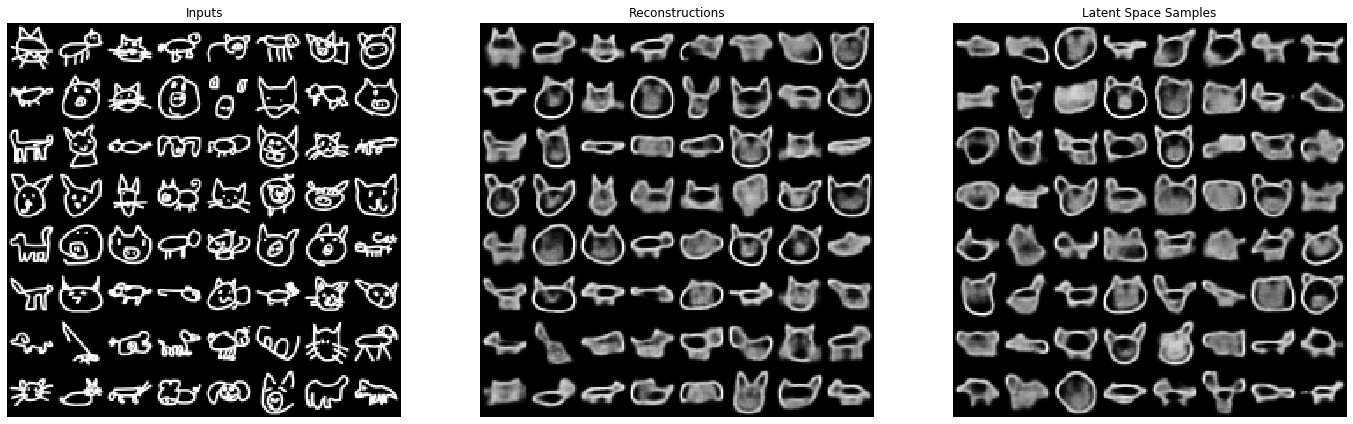

====> Test set loss: 222.5151


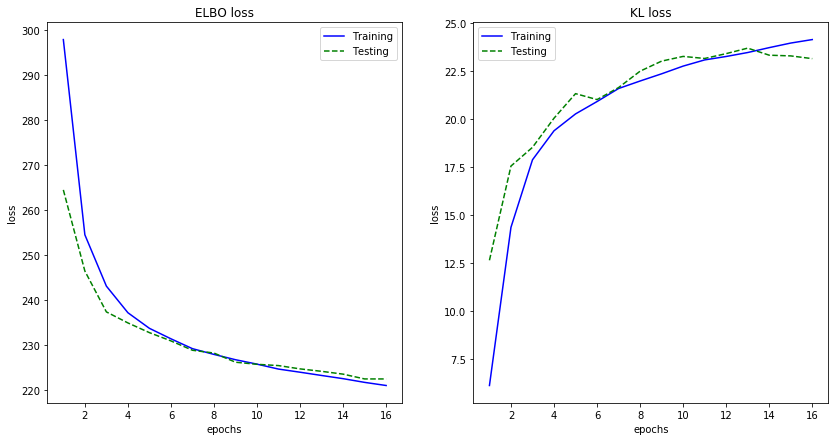

################################################################
Train Epoch: 17 [0/24000 (0%)]	Loss: 222.429886
Train Epoch: 17 [1024/24000 (4%)]	Loss: 217.847214
Train Epoch: 17 [2048/24000 (9%)]	Loss: 224.303741
Train Epoch: 17 [3072/24000 (13%)]	Loss: 218.927109
Train Epoch: 17 [4096/24000 (17%)]	Loss: 228.410797
Train Epoch: 17 [5120/24000 (21%)]	Loss: 231.482300
Train Epoch: 17 [6144/24000 (26%)]	Loss: 215.052719
Train Epoch: 17 [7168/24000 (30%)]	Loss: 215.213058
Train Epoch: 17 [8192/24000 (34%)]	Loss: 211.781906
Train Epoch: 17 [9216/24000 (38%)]	Loss: 227.439514
Train Epoch: 17 [10240/24000 (43%)]	Loss: 215.729767
Train Epoch: 17 [11264/24000 (47%)]	Loss: 237.578812
Train Epoch: 17 [12288/24000 (51%)]	Loss: 221.956665
Train Epoch: 17 [13312/24000 (55%)]	Loss: 226.261337
Train Epoch: 17 [14336/24000 (60%)]	Loss: 228.165237
Train Epoch: 17 [15360/24000 (64%)]	Loss: 224.782639
Train Epoch: 17 [16384/24000 (68%)]	Loss: 210.740051
Train Epoch: 17 [17408/24000 (73%)]	Loss: 224.2879

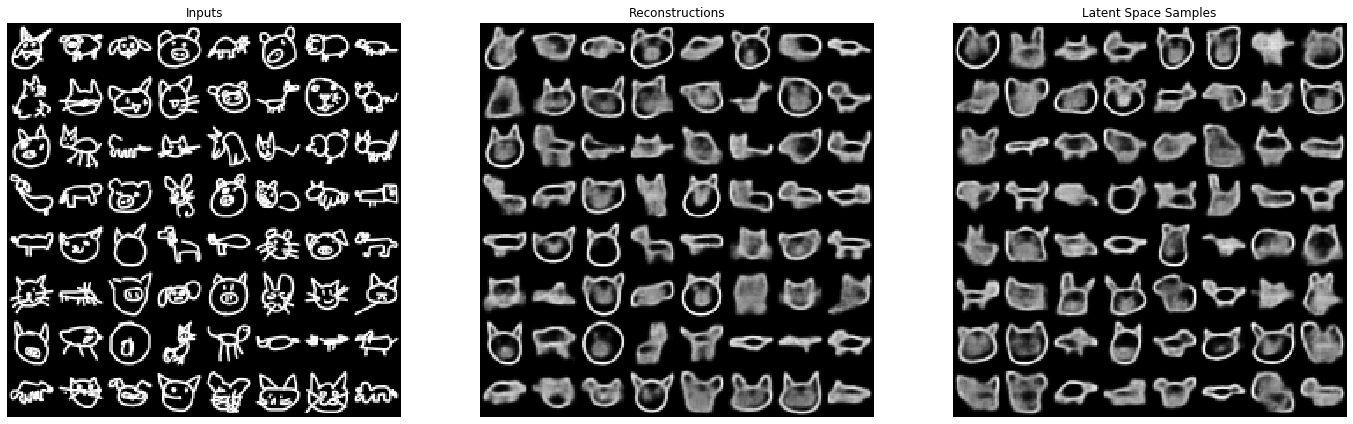

====> Test set loss: 222.1557


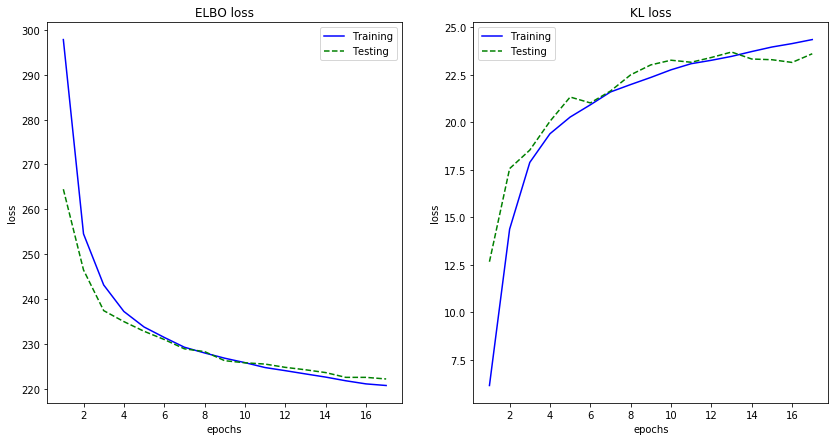

################################################################
Train Epoch: 18 [0/24000 (0%)]	Loss: 212.332443
Train Epoch: 18 [1024/24000 (4%)]	Loss: 212.979492
Train Epoch: 18 [2048/24000 (9%)]	Loss: 222.415955
Train Epoch: 18 [3072/24000 (13%)]	Loss: 205.347290
Train Epoch: 18 [4096/24000 (17%)]	Loss: 220.629532
Train Epoch: 18 [5120/24000 (21%)]	Loss: 208.510712
Train Epoch: 18 [6144/24000 (26%)]	Loss: 221.874176
Train Epoch: 18 [7168/24000 (30%)]	Loss: 221.060455
Train Epoch: 18 [8192/24000 (34%)]	Loss: 220.584915
Train Epoch: 18 [9216/24000 (38%)]	Loss: 214.256393
Train Epoch: 18 [10240/24000 (43%)]	Loss: 220.767181
Train Epoch: 18 [11264/24000 (47%)]	Loss: 223.678909
Train Epoch: 18 [12288/24000 (51%)]	Loss: 232.619019
Train Epoch: 18 [13312/24000 (55%)]	Loss: 216.038391
Train Epoch: 18 [14336/24000 (60%)]	Loss: 216.316238
Train Epoch: 18 [15360/24000 (64%)]	Loss: 208.529617
Train Epoch: 18 [16384/24000 (68%)]	Loss: 208.052353
Train Epoch: 18 [17408/24000 (73%)]	Loss: 211.3836

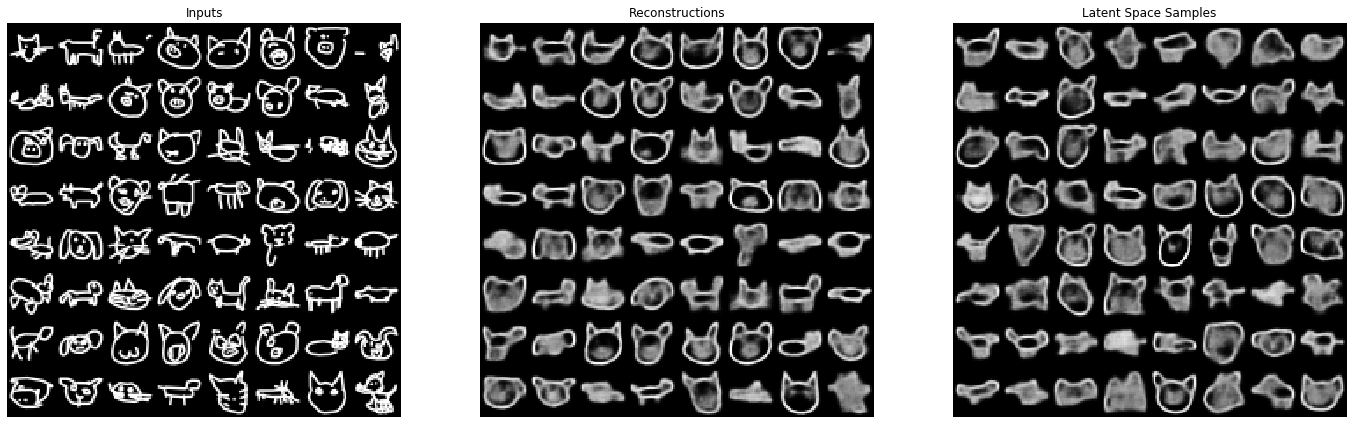

====> Test set loss: 221.1404


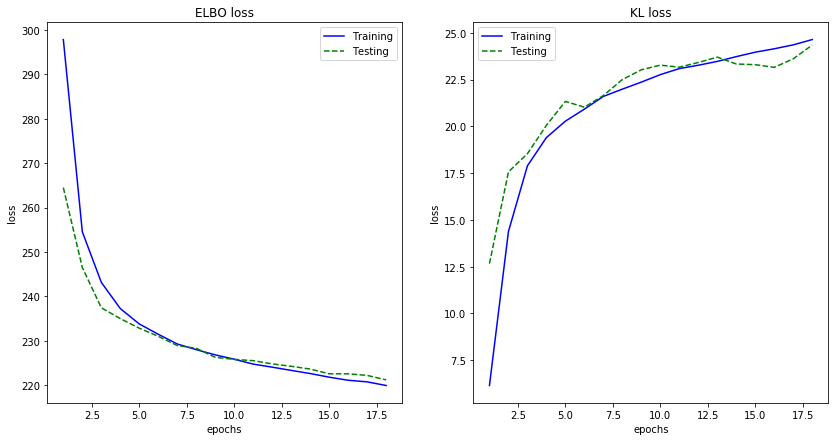

################################################################
Train Epoch: 19 [0/24000 (0%)]	Loss: 203.826828
Train Epoch: 19 [1024/24000 (4%)]	Loss: 217.994095
Train Epoch: 19 [2048/24000 (9%)]	Loss: 216.600510
Train Epoch: 19 [3072/24000 (13%)]	Loss: 220.970566
Train Epoch: 19 [4096/24000 (17%)]	Loss: 222.791183
Train Epoch: 19 [5120/24000 (21%)]	Loss: 227.957062
Train Epoch: 19 [6144/24000 (26%)]	Loss: 220.972794
Train Epoch: 19 [7168/24000 (30%)]	Loss: 226.104370
Train Epoch: 19 [8192/24000 (34%)]	Loss: 230.143799
Train Epoch: 19 [9216/24000 (38%)]	Loss: 219.476151
Train Epoch: 19 [10240/24000 (43%)]	Loss: 222.853455
Train Epoch: 19 [11264/24000 (47%)]	Loss: 218.693741
Train Epoch: 19 [12288/24000 (51%)]	Loss: 218.627563
Train Epoch: 19 [13312/24000 (55%)]	Loss: 209.951187
Train Epoch: 19 [14336/24000 (60%)]	Loss: 208.196869
Train Epoch: 19 [15360/24000 (64%)]	Loss: 228.986511
Train Epoch: 19 [16384/24000 (68%)]	Loss: 215.789246
Train Epoch: 19 [17408/24000 (73%)]	Loss: 207.2833

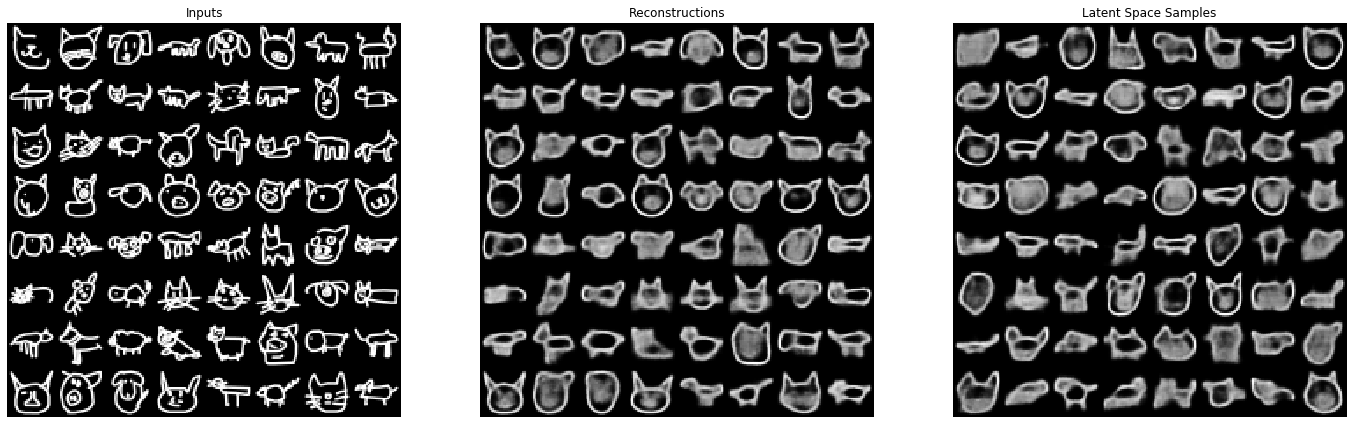

====> Test set loss: 220.8122


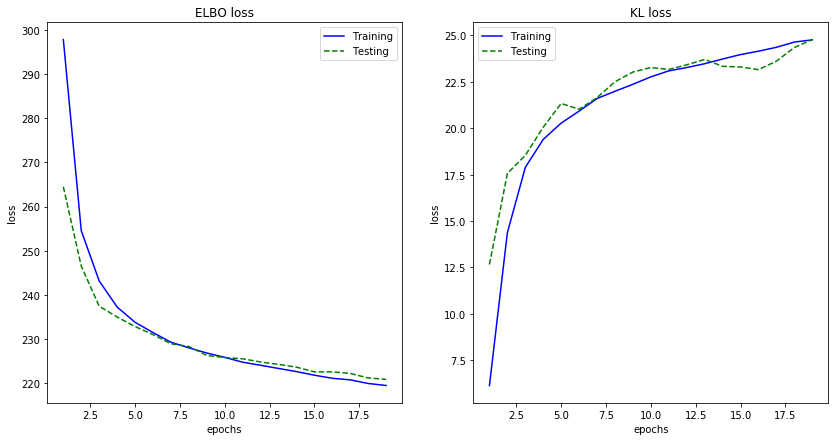

################################################################
Train Epoch: 20 [0/24000 (0%)]	Loss: 220.677567
Train Epoch: 20 [1024/24000 (4%)]	Loss: 218.518021
Train Epoch: 20 [2048/24000 (9%)]	Loss: 225.351624
Train Epoch: 20 [3072/24000 (13%)]	Loss: 215.374954
Train Epoch: 20 [4096/24000 (17%)]	Loss: 236.233780
Train Epoch: 20 [5120/24000 (21%)]	Loss: 235.255249
Train Epoch: 20 [6144/24000 (26%)]	Loss: 216.816406
Train Epoch: 20 [7168/24000 (30%)]	Loss: 219.974838
Train Epoch: 20 [8192/24000 (34%)]	Loss: 218.789474
Train Epoch: 20 [9216/24000 (38%)]	Loss: 229.501328
Train Epoch: 20 [10240/24000 (43%)]	Loss: 201.405792
Train Epoch: 20 [11264/24000 (47%)]	Loss: 219.015991
Train Epoch: 20 [12288/24000 (51%)]	Loss: 224.999878
Train Epoch: 20 [13312/24000 (55%)]	Loss: 220.690109
Train Epoch: 20 [14336/24000 (60%)]	Loss: 215.972824
Train Epoch: 20 [15360/24000 (64%)]	Loss: 213.123901
Train Epoch: 20 [16384/24000 (68%)]	Loss: 216.231354
Train Epoch: 20 [17408/24000 (73%)]	Loss: 226.9167

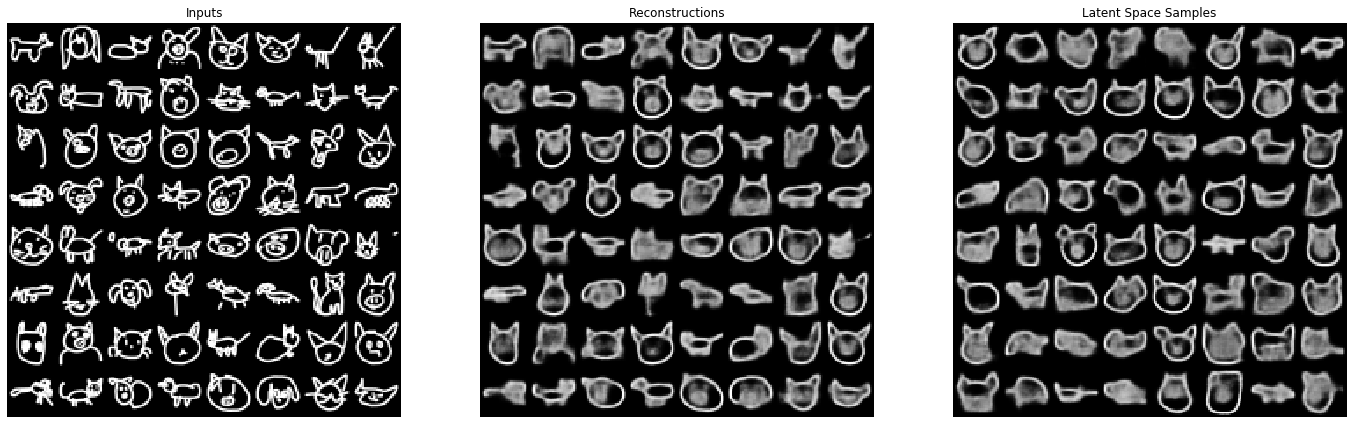

====> Test set loss: 220.6813


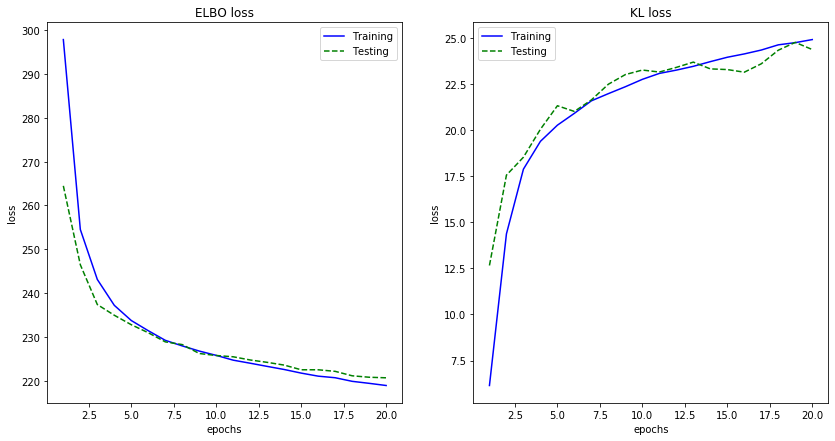

################################################################


In [16]:
model = conv_VAE().to(device) if use_conv else VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

if __name__ == "__main__":

    epoch_list = []
    epoch_loss_train, epoch_kl_train = [], [] # Train losses per epoch (mean of batch losses)
    epoch_loss_test, epoch_kl_test = [], [] # Test losses per epoch (mean of batch losses)
    
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        
        epoch_list.append(epoch)
        if epoch == 1:
            continue

        plot_losses(epoch_list, epoch_loss_train, epoch_loss_test, epoch_kl_train, epoch_kl_test)
        print("################################################################")
            
        # save_image(sample.view(64, 1, 28, 28),
        #            'results/sample_' + str(epoch) + '.png')
        #clear_output(wait=True)


In [0]:
# Save the trained model
now = datetime.now()
current_datetime = now.strftime("%d-%m-%Y_%H-%M-%S")
filepath = os.path.join("gdrive/My Drive/model", f"trained_{current_datetime}.pt") 
torch.save(model.state_dict(), filepath)

# Interpolation

In [0]:
images, labels = next(iter(train_loader))

In [0]:
def interpolate(trn_model, images, idx_from, idx_to, steps):

    # get input images
    x_from = images[idx_from].unsqueeze(0)
    x_to = images[idx_to].unsqueeze(0)
    interpolate_images(trn_model, x_to, x_from, steps)

def interpolate_images(trn_model, img_from, img_to, steps):

    # get labels
    # lab_to = labels[idx_to]
    # lab_from = labels[idx_from]  

    # get latent space representations of input images
    latent_from = trn_model.reparametrize(*trn_model.encode(img_from.to(device)))
    latent_to = trn_model.reparametrize(*trn_model.encode(img_to.to(device)))

    # actual steps including original images
    n = steps + 1 

    # initialize interpolation vector)
    inter = torch.zeros((n, latent_from.shape[1])).to(device)

    with torch.no_grad():
        alphaValues = np.linspace(0, 1, steps + 1)
        
        for i in range(n):
            alpha = alphaValues[i]
            inter[i] = latent_from * alpha + (1-alpha) * latent_to
        
        output = trn_model.decode(inter).cpu()
        plot_interpolated_images(output)

In [20]:
# Load the model for inference 
trn_model = conv_VAE().to(device)
trn_model.load_state_dict(torch.load(filepath))
trn_model.eval()

conv_VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(1024, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Con

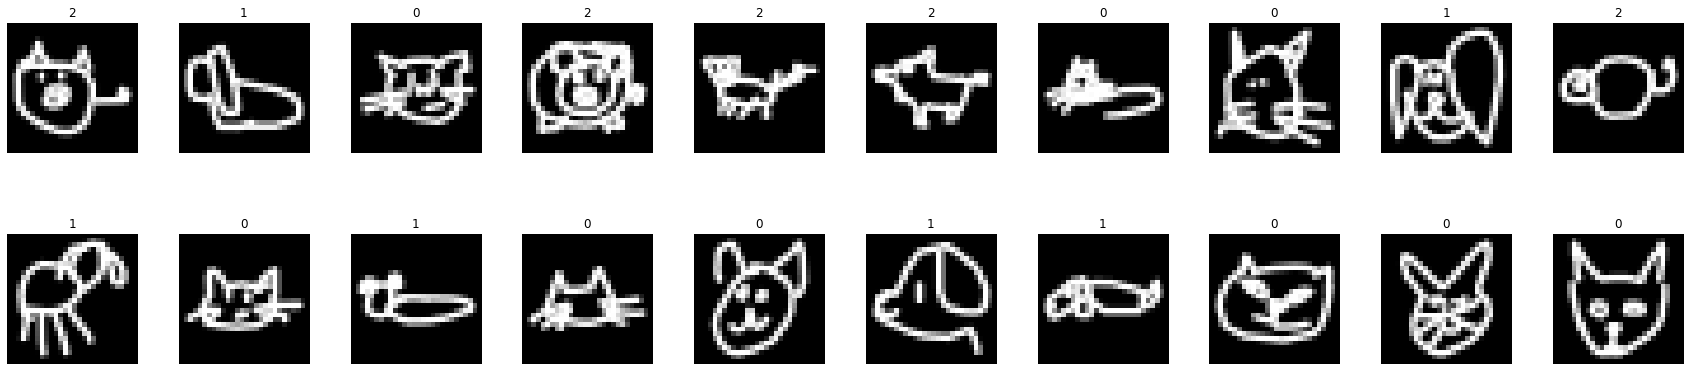

In [21]:
# Show possible images for interpolation
f, axarr = plt.subplots(2, 10, figsize=(24, 6))
f.tight_layout()

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.title.set_text(labels[i].item())
    ax.axis('off')
    
plt.show()

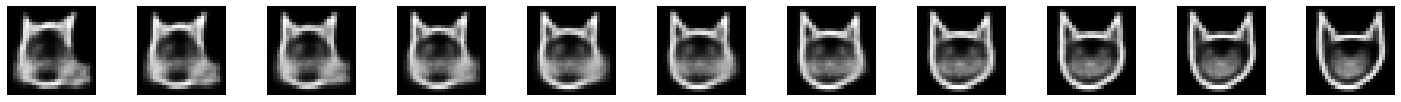

In [23]:
STEPS = 10
INDEX_FROM = 7
INDEX_TO = 19

interpolate(trn_model, images, INDEX_FROM, INDEX_TO, STEPS)